# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos Agonistas de la Hormona GLP-1**

### Avance 6: Conclusiones finales

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dra. Eduviges Ludivina Facundo Flores  – Profesor Tutor

### **Asesores**
- Dr. Juan Arturo Nolazco Flores
- Dr. Carlos Alberto Brizuela Rodríguez

#### **Miembros del equipo:**
- Cesar Ivan Herrera Martinez A01796392  
- Juan Antonio Cruz Acosta A01795375 
- Julio Baltazar Colín A01794476 

# Modelos Generativos finales
Generación de Nuevas secuencias Peptídicas Agonistas de GLP-1 mediante Modelos de Lenguaje y Evaluación In Silico de su Actividad Biológica
Para esta ultima fase del proyecto, se implementaron los modelos generativos de lenguaje natural (NLP) para la generación de nuevas secuencias peptídicas agonistas de GLP-1: un modelo basado en LSTM y otro basado en Transformers. Ambos modelos fueron entrenados utilizando el conjunto de datos curado y preprocesado de secuencias peptídicas agonistas de GLP-1. En esta ocación se reentrenaron los modelos con las mejores secuencias obtenidas en la fase anterior, con el objetivo de mejorar la calidad y diversidad de las secuencias generadas.

## Preparación de los datos y predicción de características faltantes

In [1]:
# Carga de bibliotecas

import os
import sys
import torch
import numpy as np
import pandas as pd
from pathlib import Path
# iFeature cambia la configuración de matplotlib, por lo que se debe volver a activar
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# ruta del directorio del notebook actual
notebook_dir = Path.cwd()
directorio_base = Path.cwd().parent
sys.path.append(str(directorio_base))

from src.plotting import plot_pca_3d, clasificar_y_graficar_cuantiles

In [2]:
# carga de Modelos de Machine Learning y Transformers
from sklearn.model_selection import train_test_split
from transformers import (
    XLNetLMHeadModel,
    XLNetTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import Dataset

from src.ProtXLNet_generator import generate_with_protxlnet_pipeline
from src.ProtGPT2_generator import generate_with_protgpt2_pipeline

import random
random.seed(132400)

In [3]:
# Establecer la ruta los archivos de datos

directorio_datos = Path(directorio_base / "data")
directorio_modelos = Path(directorio_base / "models")
directorio_modelos_automl= Path(directorio_modelos / "pycaret")
raw_data_dir = directorio_datos / "raw"
processed_data_dir = directorio_datos / "processed"

#ruta a los modelos automl
ruta_mejor_modelo_final = directorio_modelos_automl / "modelos_GLP1_no_pca" /"mejor_modelo_final"
# Ruta modelos generativos
ruta_modelo_protxlnet = directorio_modelos / "prot_xlnet_finetuned"

# Datos con actividad conocida
ruta_125_ec50 = processed_data_dir / "descriptores_125.csv"

# Datos con actividad predicha
ruta_predicciones_glp1 = processed_data_dir / "predicciones_glp1.csv"

# Datos sin actividad conocida
ruta_peptidos_eval = processed_data_dir / "descriptores_cdhit.csv"

#Datos de identificacion de secuencias con especie
ruta_glucagon_like_peptides = processed_data_dir / "glucagon_like_peptides.csv"

# directorio para nuevas secuencias 
directorio_nuevas_secuencias = Path(processed_data_dir/"Actividad_6"/"secuencias_nuevas")
os.makedirs(directorio_nuevas_secuencias, exist_ok=True)

# directorio modelos peptide Bert
directorio_modelos_peptidebert = directorio_modelos / "peptideBert"


# directorio temporal
directorio_temporal = Path(directorio_base / "temp")
os.makedirs(directorio_temporal, exist_ok=True)


In [4]:
# Carga de datos
# Cargar datos procesados con anterioridad

# datos con actividad Biologica EC 50 conocida
df_125_conocidos = pd.read_csv(ruta_125_ec50)
df_125_conocidos.columns = df_125_conocidos.columns.str.replace('.', '_', regex=False)
df_125_conocidos['-1pEC50'] = -np.log10(df_125_conocidos["EC50_T2"] * 1e-12)

# datos con alta diversidad usados para entrenamiento de los modelos generativos
df_glp1 = pd.read_csv(ruta_peptidos_eval)
df_glp1.columns = df_glp1.columns.str.replace('.', '_', regex=False)

# conjunto de datos de secuencias similares al GLP-1 humano procedentes de Alphafold y  UniProt
df_glucagon_like_peptides = pd.read_csv(ruta_glucagon_like_peptides)
df_glucagon_like_peptides['ID'] = df_glucagon_like_peptides['ID'].str.replace("|", "-")
df_glucagon_like_peptides = df_glucagon_like_peptides[ ["ID", "Description", "GLP-1_Activo", "Species", "organismCommonNames"]].rename(columns={'GLP-1_Activo': 'sequence'})

# Datos con actividad Biologica EC 50 predicha
df_protxlnet = pd.read_csv(processed_data_dir/"Actividad_5/secuencias_nuevas/secuencias_nuevas_protxlnet_820251026_232714.csv")
df_protgpt = pd.read_csv(processed_data_dir/"Actividad_5/secuencias_nuevas/secuencias_nuevas_protxlnet_820251026_232714.csv")


In [5]:
# cargar las configuraciones de iFeature Omega
from src.ifeature_process import calcular_descriptores_ifeature
ifeatures_settings_json = Path(directorio_datos / 
                               "iFeature Settings" / 
                               "Protein_parameters_setting.json") 
ifeatures_settings_json
# Definimos la lista de descriptores a calcular
descriptores = [
            "AAC",				# Amino acid composition
            "CKSAAGP type 1",	# Composition of k-spaced amino acid group pairs type 1- normalized
            "DPC type 1",		# Dipeptide composition type 1 - normalized
            "CTDC",				# Composition
            "CTDT",				# Transition
            "CTDD",				# Distribution
            "CTriad",			# Conjoint triad
            "GAAC",				# Grouped amino acid composition
            "Moran",			# Moran
            "SOCNumber",		# Sequence-order-coupling number
            "QSOrder",			# Quasi-sequence-order descriptors
            "PAAC",				# Pseudo-amino acid composition
            "APAAC",			# Amphiphilic PAAC
            "NMBroto",			# Auto-cross covariance
        ]

In [6]:
print(f"secuencias con actividad conocida: {len(df_125_conocidos)}")
display(df_125_conocidos.head(2))
print(f"secuencias con procedentes de uniprot: {len(df_glucagon_like_peptides)}")
display(df_glucagon_like_peptides.head(2))
print(f"secuencias con generadas con ProTxLNet: {len(df_protxlnet)}")
display(df_protxlnet.head(2))
print(f"secuencias con generadas con ProtGPT: {len(df_protgpt)}")
display(df_protgpt.head(2))

secuencias con actividad conocida: 125


,ID,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,NMBroto_BEGF750103_lag1,NMBroto_BEGF750103_lag2,NMBroto_BEGF750103_lag3,NMBroto_BHAR880101_lag1,NMBroto_BHAR880101_lag2,NMBroto_BHAR880101_lag3,sequence,EC50_T2,EC50_LOG_T2,-1pEC50
0,seq_pep1,0.033333,0.0,0.1,0.1,0.066667,0.066667,0.033333,0.0,0.033333,...,-0.02798,-0.182783,0.054222,0.190428,-0.142437,0.090372,HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE,563.0,-9.25,9.249492
1,seq_pep2,0.033333,0.0,0.1,0.1,0.066667,0.066667,0.033333,0.0,0.033333,...,0.00091,-0.316149,0.170202,0.157133,-0.144228,0.115217,HSQGTFTSDYSKYLDSRRAEDFVQWLENGE,552.0,-9.26,9.258061


secuencias con procedentes de uniprot: 897


,ID,Description,sequence,Species,organismCommonNames
0,AF-A0A060VXS0-F1,Uncharacterized protein,HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR,Oncorhynchus mykiss,NaN
1,AF-A0A060VY52-F1,Uncharacterized protein,HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR,Oncorhynchus mykiss,NaN


secuencias con generadas con ProTxLNet: 1596


,ID,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,NMBroto_BEGF750103_lag2,NMBroto_BEGF750103_lag3,NMBroto_BHAR880101_lag1,NMBroto_BHAR880101_lag2,NMBroto_BHAR880101_lag3,sequence,prediccion_-1pEC50,hemo,sol,nf
0,secuencia_1,0.121951,0.00000,0.04878,0.04878,0.04878,0.097561,0.00000,0.04878,0.02439,...,0.131043,-0.112464,0.217984,-0.007832,0.169623,YAEGTFTSDYSIYLDIKAAQEFVNWTLAGGPSSGAPPPSPT,10.219507,0.060340,0.575337,0.012731
1,secuencia_2,0.121951,0.04878,0.04878,0.00000,0.04878,0.146341,0.02439,0.00000,0.02439,...,-0.012470,0.144327,0.309305,-0.016205,0.131224,HLQGTFTSDYSKYLDSRAAACFVQWLLNGGPSSGAPPCGGA,10.523143,0.057503,0.788021,0.009991


secuencias con generadas con ProtGPT: 1596


,ID,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,NMBroto_BEGF750103_lag2,NMBroto_BEGF750103_lag3,NMBroto_BHAR880101_lag1,NMBroto_BHAR880101_lag2,NMBroto_BHAR880101_lag3,sequence,prediccion_-1pEC50,hemo,sol,nf
0,secuencia_1,0.121951,0.00000,0.04878,0.04878,0.04878,0.097561,0.00000,0.04878,0.02439,...,0.131043,-0.112464,0.217984,-0.007832,0.169623,YAEGTFTSDYSIYLDIKAAQEFVNWTLAGGPSSGAPPPSPT,10.219507,0.060340,0.575337,0.012731
1,secuencia_2,0.121951,0.04878,0.04878,0.00000,0.04878,0.146341,0.02439,0.00000,0.02439,...,-0.012470,0.144327,0.309305,-0.016205,0.131224,HLQGTFTSDYSKYLDSRAAACFVQWLLNGGPSSGAPPCGGA,10.523143,0.057503,0.788021,0.009991


### Predicción de la actividad Biologica del conjunto de secuencias sin predecir

In [7]:
# cargar el modelo guardado para predicciones con PyCaret
from src.PeptideBert_predict import predict_peptidebert
from pycaret.regression import load_model, predict_model
modelo_pycaret = load_model(ruta_mejor_modelo_final)
modelo_pycaret

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['AAC_A', 'AAC_C', 'AAC_D', 'AAC_E',
                                             'AAC_F', 'AAC_G', 'AAC_H', 'AAC_I',
                                             'AAC_K', 'AAC_L', 'AAC_M', 'AAC_N',
                                             'AAC_P', 'AAC_Q', 'AAC_R', 'AAC_S',
                                             'AAC_T', 'AAC_V', 'AAC_W', 'AAC_Y',
                                             'CKSAAGP_alphaticr_alphaticr_gap0',
                                             'CKSAAGP_alphaticr_aromatic_gap0',
                                             'CKSAAGP_alphaticr_postivec...
                                              ExtraTreesRegressor(criterion='absolute_error',
                                                                  max_depth=5,
                                                                  max_features=0.567711756337121,
                                                                  min_impurity_decrease=0.005297055476899181,
                                                                  min_samples_leaf=2,
                                                                  n_estimators=155,
                                                                  n_jobs=-1,
                                                                  random_state=132400)),
                                             ('Huber Regressor',
                                              HuberRegressor(alpha=0.987530237988201,
                                                             epsilon=1.5704959650312693))],
                                 n_jobs=-1,
                                 weights=[0.33891719768937995,
                                          0.1387358959195408,
                                          0.17830429140572182]))])

In [8]:
# Cálculo de descriptores iFeature Omega para las secuencias similares al GLP-1 humano procedentes de Alpha Fold y UniProt
df_glucagon_like_peptides = calcular_descriptores_ifeature(
        directorio_temporal=directorio_temporal,
        dataframe=df_glucagon_like_peptides,
        sequence_col='sequence',
        id_col='ID',
        descriptores=descriptores,
        ifeatures_settings_json=ifeatures_settings_json
    )

Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_135828.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_135828.fasta...
  - OK! File is structurally valid. Found 897 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_135828.fasta' es válido. Se encontraron 897 registros.
Iniciando cálculo de 14 descriptores...
  - OK! File is structurally valid. Found 897 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_135828.fasta' es válido. Se encontraron 897 registros.
Iniciando cálculo de 14 descriptores...


calculando descriptores:   0%|          | 0/14 [00:00<?, ?it/s]

File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
Cálculo de descriptores finalizado.
Descriptores unidos al DataFrame. Forma final: (897, 1295)
Archivo temporal 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_135828.fasta' eliminado.
Cálculo de descriptores finalizado.
Descriptores unido

In [9]:
# Cálculo de pEC50 sobre los datos de alpha fold y uniprot
df_glucagon_like_peptides = predict_model(modelo_pycaret, data=df_glucagon_like_peptides)
df_glucagon_like_peptides.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
# Predicciones con PeptideBert para el conjunto obtenido de la base de datos de Aphafold
df_glucagon_like_peptides = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_glucagon_like_peptides, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)
df_glucagon_like_peptides[["ID","sequence","sol","hemo", "nf", "prediccion_-1pEC50"]].head()

Usando dispositivo: cuda
Procesando caracteristica: hemo
Procesando caracteristica: hemo


  0%|          | 0/897 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/897 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/897 [00:00<?, ?it/s]

,ID,sequence,sol,hemo,nf,prediccion_-1pEC50
0,AF-A0A060VXS0-F1,HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR,0.813716,0.051502,0.023509,8.729368
1,AF-A0A060VY52-F1,HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR,0.844703,0.054030,0.020588,8.988079
2,AF-A0A060WDT4-F1,HADGTYTSDVSTYLQDQAAKDFVSWLKSGL,0.796401,0.068710,0.016539,9.318927
3,AF-A0A087VEU7-F1,HAEGTYTSDITSYLEGQAAKEFIAWLVNGR,0.730178,0.066916,0.009954,9.398033
4,AF-A0A087XPV4-F1,HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ,0.807739,0.059716,0.020352,9.803035


In [10]:
# Calculo de pEC50 sobre los datos con actividad conocida usados para entrenar el modelo predictivo
df_125_conocidos = predict_model(modelo_pycaret, data=df_125_conocidos)
df_125_conocidos.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
# Predicciones con PeptideBert para los 125 péptidos similares con actividad ec50 conocida
df_125_conocidos = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_125_conocidos, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)
df_125_conocidos[["ID","sequence","sol","hemo", "nf","-1pEC50","prediccion_-1pEC50"]].head()

Usando dispositivo: cuda
Procesando caracteristica: hemo
Procesando caracteristica: hemo


  0%|          | 0/125 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/125 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/125 [00:00<?, ?it/s]

,ID,sequence,sol,hemo,nf,-1pEC50,prediccion_-1pEC50
0,seq_pep1,HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE,0.849804,0.055827,0.034196,9.249492,9.256478
1,seq_pep2,HSQGTFTSDYSKYLDSRRAEDFVQWLENGE,0.845523,0.052318,0.031188,9.258060,9.328444
2,seq_pep3,HSQGTFTSDYSKYLDSRRAEDFVQWLENT,0.786436,0.052129,0.027671,9.598599,9.321180
3,seq_pep4,HSQGTFTSDYSKYLDSRRAEDFVQWLVAGGSGSGSG,0.843368,0.055343,0.028107,11.219683,11.209304
4,seq_pep5,HSQGTFTSDYSKYLDSRRAQDFVQWLEAEG,0.811992,0.056414,0.027693,9.623423,9.573532


In [11]:
print(f"secuencias con actividad conocida: {len(df_125_conocidos)}")
display(df_125_conocidos.head(2))
print(f"secuencias con procedentes de uniprot: {len(df_glucagon_like_peptides)}")
display(df_glucagon_like_peptides.head(2))
print(f"secuencias con generadas con ProTxLNet: {len(df_protxlnet)}")
display(df_protxlnet.head(2))
print(f"secuencias con generadas con ProtGPT: {len(df_protgpt)}")
display(df_protgpt.head(2))

secuencias con actividad conocida: 125


,ID,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,NMBroto_BHAR880101_lag2,NMBroto_BHAR880101_lag3,sequence,EC50_T2,EC50_LOG_T2,-1pEC50,prediccion_-1pEC50,hemo,sol,nf
0,seq_pep1,0.033333,0.0,0.1,0.1,0.066667,0.066667,0.033333,0.0,0.033333,...,-0.142437,0.090372,HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE,563.0,-9.25,9.249492,9.256478,0.055827,0.849804,0.034196
1,seq_pep2,0.033333,0.0,0.1,0.1,0.066667,0.066667,0.033333,0.0,0.033333,...,-0.144228,0.115217,HSQGTFTSDYSKYLDSRRAEDFVQWLENGE,552.0,-9.26,9.258060,9.328444,0.052318,0.845523,0.031188


secuencias con procedentes de uniprot: 897


,ID,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,NMBroto_BHAR880101_lag2,NMBroto_BHAR880101_lag3,Description,sequence,Species,organismCommonNames,prediccion_-1pEC50,hemo,sol,nf
0,AF-A0A060VXS0-F1,0.1,0.0,0.066667,0.066667,0.033333,0.066667,0.033333,0.0,0.066667,...,-0.372417,0.041586,Uncharacterized protein,HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR,Oncorhynchus mykiss,NaN,8.729368,0.051502,0.813716,0.023509
1,AF-A0A060VY52-F1,0.1,0.0,0.066667,0.066667,0.033333,0.066667,0.033333,0.0,0.066667,...,-0.292699,0.046946,Uncharacterized protein,HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR,Oncorhynchus mykiss,NaN,8.988079,0.054030,0.844703,0.020588


secuencias con generadas con ProTxLNet: 1596


,ID,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,NMBroto_BEGF750103_lag2,NMBroto_BEGF750103_lag3,NMBroto_BHAR880101_lag1,NMBroto_BHAR880101_lag2,NMBroto_BHAR880101_lag3,sequence,prediccion_-1pEC50,hemo,sol,nf
0,secuencia_1,0.121951,0.00000,0.04878,0.04878,0.04878,0.097561,0.00000,0.04878,0.02439,...,0.131043,-0.112464,0.217984,-0.007832,0.169623,YAEGTFTSDYSIYLDIKAAQEFVNWTLAGGPSSGAPPPSPT,10.219507,0.060340,0.575337,0.012731
1,secuencia_2,0.121951,0.04878,0.04878,0.00000,0.04878,0.146341,0.02439,0.00000,0.02439,...,-0.012470,0.144327,0.309305,-0.016205,0.131224,HLQGTFTSDYSKYLDSRAAACFVQWLLNGGPSSGAPPCGGA,10.523143,0.057503,0.788021,0.009991


secuencias con generadas con ProtGPT: 1596


,ID,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,NMBroto_BEGF750103_lag2,NMBroto_BEGF750103_lag3,NMBroto_BHAR880101_lag1,NMBroto_BHAR880101_lag2,NMBroto_BHAR880101_lag3,sequence,prediccion_-1pEC50,hemo,sol,nf
0,secuencia_1,0.121951,0.00000,0.04878,0.04878,0.04878,0.097561,0.00000,0.04878,0.02439,...,0.131043,-0.112464,0.217984,-0.007832,0.169623,YAEGTFTSDYSIYLDIKAAQEFVNWTLAGGPSSGAPPPSPT,10.219507,0.060340,0.575337,0.012731
1,secuencia_2,0.121951,0.04878,0.04878,0.00000,0.04878,0.146341,0.02439,0.00000,0.02439,...,-0.012470,0.144327,0.309305,-0.016205,0.131224,HLQGTFTSDYSKYLDSRAAACFVQWLLNGGPSSGAPPCGGA,10.523143,0.057503,0.788021,0.009991


In [80]:
# obtener los resultados del pro-glucagon Humano como referencia
df_pro_glucagon_humano = df_glucagon_like_peptides[df_glucagon_like_peptides['ID'].str.contains("human", case=False, na=False)]
df_pro_glucagon_humano

,ID,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,NMBroto_BHAR880101_lag2,NMBroto_BHAR880101_lag3,Description,sequence,Species,organismCommonNames,prediccion_-1pEC50,hemo,sol,nf
875,sp-P01275-GLUC_HUMAN,0.133333,0.0,0.033333,0.1,0.066667,0.1,0.033333,0.033333,0.066667,...,-0.305108,-0.179249,Glucagon,HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR,Pan troglodytes,Chimpanzee,10.234846,0.066893,0.825296,0.009175


## Selección de secuencias como prompt
En esta ocación se seleccionaron las mejores secuencias obtenidas en la actividad anterior, junto con las secuencias con mejores características procedentes de las bases de datos externas (UniProt y AlphaFold).

In [13]:
# Selección de secuencias como prompt

# Unir todos los dataframes
df_combined = pd.concat([
    df_pro_glucagon_humano,
    df_125_conocidos,
    df_glucagon_like_peptides,
    df_protxlnet,
    df_protgpt
], ignore_index=True)

print(f"Total de secuencias antes de eliminar duplicados: {len(df_combined)}")

# Eliminar duplicados basándose en la columna 'sequence'
df_combined = df_combined.drop_duplicates(subset=['sequence'], keep='first')

print(f"Total de secuencias después de eliminar duplicados: {len(df_combined)}")
print(f"Duplicados eliminados: {len(pd.concat([df_125_conocidos, df_glucagon_like_peptides, df_protxlnet, df_protgpt], ignore_index=True)) - len(df_combined)}")

# Mostrar información del dataframe combinado
print("\nColumnas disponibles:")
print(df_combined.columns.tolist())
print("\nPrimeras filas del dataframe combinado:")
display(df_combined.head())

Total de secuencias antes de eliminar duplicados: 4215
Total de secuencias después de eliminar duplicados: 1961
Duplicados eliminados: 2253

Columnas disponibles:
['ID', 'AAC_A', 'AAC_C', 'AAC_D', 'AAC_E', 'AAC_F', 'AAC_G', 'AAC_H', 'AAC_I', 'AAC_K', 'AAC_L', 'AAC_M', 'AAC_N', 'AAC_P', 'AAC_Q', 'AAC_R', 'AAC_S', 'AAC_T', 'AAC_V', 'AAC_W', 'AAC_Y', 'CKSAAGP_alphaticr_alphaticr_gap0', 'CKSAAGP_alphaticr_aromatic_gap0', 'CKSAAGP_alphaticr_postivecharger_gap0', 'CKSAAGP_alphaticr_negativecharger_gap0', 'CKSAAGP_alphaticr_uncharger_gap0', 'CKSAAGP_aromatic_alphaticr_gap0', 'CKSAAGP_aromatic_aromatic_gap0', 'CKSAAGP_aromatic_postivecharger_gap0', 'CKSAAGP_aromatic_negativecharger_gap0', 'CKSAAGP_aromatic_uncharger_gap0', 'CKSAAGP_postivecharger_alphaticr_gap0', 'CKSAAGP_postivecharger_aromatic_gap0', 'CKSAAGP_postivecharger_postivecharger_gap0', 'CKSAAGP_postivecharger_negativecharger_gap0', 'CKSAAGP_postivecharger_uncharger_gap0', 'CKSAAGP_negativecharger_alphaticr_gap0', 'CKSAAGP_negativec

,ID,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,sequence,Species,organismCommonNames,prediccion_-1pEC50,hemo,sol,nf,EC50_T2,EC50_LOG_T2,-1pEC50
0,sp-P01275-GLUC_HUMAN,0.133333,0.0,0.033333,0.100000,0.066667,0.100000,0.033333,0.033333,0.066667,...,HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR,Pan troglodytes,Chimpanzee,10.234846,0.066893,0.825296,0.009175,NaN,NaN,NaN
1,seq_pep1,0.033333,0.0,0.100000,0.100000,0.066667,0.066667,0.033333,0.000000,0.033333,...,HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE,NaN,NaN,9.256478,0.055827,0.849804,0.034196,563.00,-9.25,9.249492
2,seq_pep2,0.033333,0.0,0.100000,0.100000,0.066667,0.066667,0.033333,0.000000,0.033333,...,HSQGTFTSDYSKYLDSRRAEDFVQWLENGE,NaN,NaN,9.328444,0.052318,0.845523,0.031188,552.00,-9.26,9.258060
3,seq_pep3,0.034483,0.0,0.103448,0.068966,0.068966,0.034483,0.034483,0.000000,0.034483,...,HSQGTFTSDYSKYLDSRRAEDFVQWLENT,NaN,NaN,9.321180,0.052129,0.786436,0.027671,252.00,-9.60,9.598599
4,seq_pep4,0.055556,0.0,0.083333,0.027778,0.055556,0.166667,0.027778,0.000000,0.027778,...,HSQGTFTSDYSKYLDSRRAEDFVQWLVAGGSGSGSG,NaN,NaN,11.209304,0.055343,0.843368,0.028107,6.03,-11.22,11.219683


In [14]:
# Selección de los mejores péptidos como prompts

df_seleccionadas = df_combined.drop_duplicates('sequence').sort_values(by=['prediccion_-1pEC50','sol','hemo','nf'], ascending=[False, False, True, True])
# Filtrar predicciones con pEC50 > 10.6 y longitud <= 60
df_seleccionadas = df_seleccionadas[
    (df_seleccionadas['prediccion_-1pEC50'] > 10.8) & 
    (df_seleccionadas['sequence'].str.len() <= 60)]

df_seleccionadas.info()
display(df_seleccionadas[["ID","sequence","prediccion_-1pEC50","sol","hemo","nf","Species","organismCommonNames"]])

<class 'pandas.core.frame.DataFrame'>
Index: 341 entries, 2589 to 1776
Columns: 1302 entries, ID to -1pEC50
dtypes: category(3), float32(3), float64(1294), object(2)
memory usage: 3.4+ MB


,ID,sequence,prediccion_-1pEC50,sol,hemo,nf,Species,organismCommonNames
2589,secuencia_1567,YSEGTFTGDLGVDVGMGGNV,11.929176,0.829813,0.080669,0.132715,NaN,NaN
2516,secuencia_1494,HSQGTFTSDYSRYLDSRRASEFVDYGSRAGLGV,11.819596,0.732158,0.059699,0.023636,NaN,NaN
26,seq_pep26,YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSSGAPPPS,11.817376,0.691562,0.070741,0.011432,NaN,NaN
1820,secuencia_798,YSEGTFTSDYSKLLERQAIDEFVNWLLKGGPSLGAPPPSGA,11.806339,0.641930,0.070540,0.009047,NaN,NaN
2365,secuencia_1343,YSEGTFTSDYSKLLEEAAVRDFIEWLLAGGPSSGAPPPSAA,11.748090,0.568676,0.070886,0.008207,NaN,NaN
...,...,...,...,...,...,...,...,...
1621,secuencia_599,HTDGTFTSDVSAYLNDRAVKEFVARLKEGQETDVSAYLND,10.805173,0.738340,0.049335,0.009746,NaN,NaN
1868,secuencia_846,HSQGTFTSDYSKYLYSERARDFVQWLVAGGTSDYSKYLYS,10.804239,0.727073,0.055615,0.008678,NaN,NaN
2042,secuencia_1020,HSQGTFTSDYSKYLDSRAAAKFVQWLLNGGPSSGSPPEGGG,10.803080,0.866876,0.046648,0.028693,NaN,NaN
1502,secuencia_480,YSQGTFTSDYSKYLEEESVRLFIEWLLAGTSDYSKYLEE,10.802447,0.587052,0.085576,0.003915,NaN,NaN


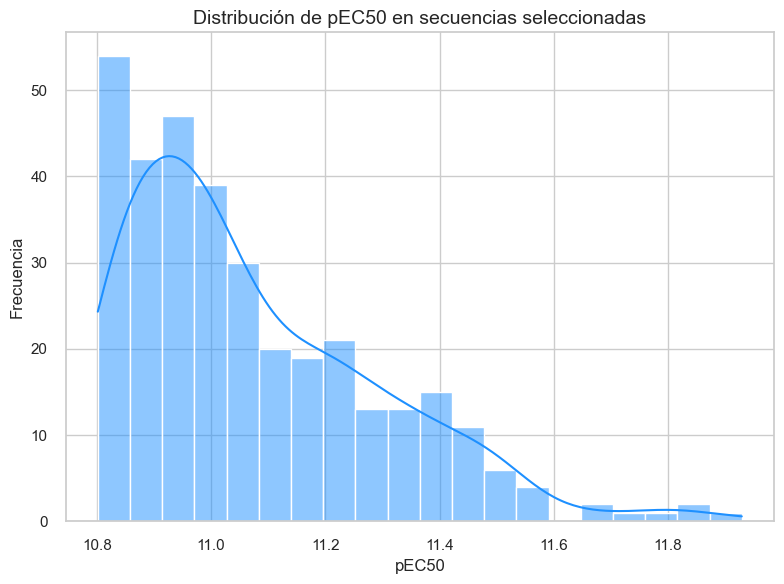

In [15]:
# Comparación de la distribución de pEC50 de las secuencias seleccionadas como semilla
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración del estilo de la visualización
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.histplot(df_seleccionadas['prediccion_-1pEC50'], kde=True, bins=20, color='dodgerblue')
plt.title('Distribución de pEC50 en secuencias seleccionadas', fontsize=14)
plt.xlabel('pEC50', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.tight_layout()
plt.show()

In [16]:
# Preparación de los prompts para la generación de nuevas secuencias para los modelos
prompt_sequences= df_seleccionadas['sequence'].tolist()
longitud_maxima = df_seleccionadas['sequence'].str.len().max()+3
longitud_minima = df_seleccionadas['sequence'].str.len().min()-3
sequences_base = df_seleccionadas['sequence'].tolist()
print(f"Longitud máxima de secuencia: {longitud_maxima}")
print(f"Longitud mínima de secuencia: {longitud_minima}")

Longitud máxima de secuencia: 44
Longitud mínima de secuencia: 13


In [17]:
# Generar un timestamp para nombrar archivos a final de evitar sobreescrituras de resultados
from datetime import datetime
# Generar timestamp en formato AñoMesDía_HoraMinutoSegundo
File_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

## Genración de nuevas secuencias con ProtGPT2

In [18]:
# Generación de secuencias usando ProtGPT2
variants = generate_with_protgpt2_pipeline(
    prompt_sequences=prompt_sequences,
    num_variants_per_seq=2,
    num_return_sequences=2,
    max_length=longitud_maxima,
    min_length=longitud_minima,
    top_k=50,
    repetition_penalty=1.0,
)
# realimentar el modelo con las secuencias generadas a fin de explorar más el espacio de secuencias
variants2 = generate_with_protgpt2_pipeline(
    prompt_sequences=variants,
    num_variants_per_seq=5,
    num_return_sequences=5,
    max_length=longitud_maxima,
    min_length=longitud_minima,
    top_k=50,
    repetition_penalty=1.0,
)



df_secuencias_protGPT2 = pd.DataFrame(variants, columns=["sequence"])
df_secuencias_protGPT2['ID'] = [f"secuencia_protgpt2_{idx}" for idx in range(1, len(df_secuencias_protGPT2) + 1)]
df_secuencias_protGPT2 = df_secuencias_protGPT2[['ID', 'sequence']]
display(df_secuencias_protGPT2.head(10))

    
df_secuencias_protGPT2_2d = pd.DataFrame(variants2, columns=["sequence"])
df_secuencias_protGPT2_2d['ID'] = [f"secuencia_protgpt2_2g_{idx}" for idx in range(1, len(df_secuencias_protGPT2_2d) + 1)]
df_secuencias_protGPT2_2d = df_secuencias_protGPT2_2d[['ID', 'sequence']]
display(df_secuencias_protGPT2_2d.head(10))



Usando dispositivo: cuda
Cargando pipeline de generación...
Cargando pipeline de generación...
Pipeline cargado.
Preparando las secuencias iniciales...
Pipeline cargado.
Preparando las secuencias iniciales...


  0%|          | 0/341 [00:00<?, ?it/s]

Generando 681 variantes (el pipeline manejará los lotes)...
Procesando salidas...
Procesando salidas...


Procesando:   0%|          | 0/681 [00:00<?, ?it/s]


Generación completada. Se obtuvieron 1282 variantes únicas.
Usando dispositivo: cuda
Cargando pipeline de generación...
Cargando pipeline de generación...
Pipeline cargado.
Preparando las secuencias iniciales...
Pipeline cargado.
Preparando las secuencias iniciales...


  0%|          | 0/1282 [00:00<?, ?it/s]

Generando 6398 variantes (el pipeline manejará los lotes)...
Procesando salidas...
Procesando salidas...


Procesando:   0%|          | 0/6398 [00:00<?, ?it/s]


Generación completada. Se obtuvieron 17560 variantes únicas.


,ID,sequence
0,secuencia_protgpt2_1,YSEGTFTSDYSKLKEEEANRLFCEWLLAGGPSSGAPPPSPPPPG
1,secuencia_protgpt2_2,RSQGTFTSDYWKYLDRAAASDFVQWLVAVLPSSNRAALTAAALQ
2,secuencia_protgpt2_3,HADGTFTSDVSAYLKEQLIKDFVAKLKAGQDFVAKLKAGQ
3,secuencia_protgpt2_4,HADGTFTSDVSAYLKEQATKDFVAKLKAGQDFVAKLKWGQ
4,secuencia_protgpt2_5,HSLRTFTSDYSKYLDSRAAAKFVQWLLNGGPSSGAPPEGGGAAG
5,secuencia_protgpt2_6,HAEGTFTSDVSAYLEGQAAKEFIAWWVKGRHVHIEANEDYERTV
6,secuencia_protgpt2_7,HSQGTFTSDYSEYLDSRAAACFVQWLLNGGPSSGAPPCNGGPTC
7,secuencia_protgpt2_8,HSQGTATSDYSKYLDSRKAAAFVQWLLNGGPSSGAPPPIEGIPR
8,secuencia_protgpt2_9,HTDGTNTSDVGAYLNDRAVKEFVARLKSGQTADVGAYFSSGTRS
9,secuencia_protgpt2_10,HSQGTFTSDESKYLDSYNATYFVYQPTNQRFFTHQS


,ID,sequence
0,secuencia_protgpt2_2g_1,HSQGHFTRSTSSSGRISSSSSRSSSSSGSSSSSGSS
1,secuencia_protgpt2_2g_2,YAEGTFTSDYSIYLDKQAAEMFVNNI
2,secuencia_protgpt2_2g_3,YAEGTFTSDYSIYLDKQAAEAFVNGLLASGPSSGAPPRSAEQPA
3,secuencia_protgpt2_2g_4,HSQGTFTSDYSKYLDSRAAAKFVQWLLNGPPSSGAPPETGTNPG
4,secuencia_protgpt2_2g_5,HSSGTFTSDYWKPLDSEDLQELIKFIEEESSDISSEKLKSSIEN
5,secuencia_protgpt2_2g_6,HSQGTFTSMYSKYLWSRAAAKFVQWLLNGQH
6,secuencia_protgpt2_2g_7,HNQGTFTSDYSQDRSHPIQHDHPVDPFQHHP
7,secuencia_protgpt2_2g_8,YSEKTDQTENFAFNYFSTQIGYKWD
8,secuencia_protgpt2_2g_9,YSEGTFKSDKKFYTYFKHGHVKSEGNYKNGKKVGSWKHYHENGK
9,secuencia_protgpt2_2g_10,HSQGTFTSDYSKYLDFRKAWAPVQWLLNYLWGGSKSRHKGTQNP


In [19]:
# Cálculo de descriptores y actividad biológica predicha para las nuevas secuencias generadas con ProtGPT2

df_secuencias_protGPT2 = calcular_descriptores_ifeature(
        directorio_temporal=directorio_temporal,
        dataframe=df_secuencias_protGPT2,
        sequence_col='sequence',
        id_col='ID',
        descriptores=descriptores,
        ifeatures_settings_json=ifeatures_settings_json
    )
    
# Calculo de pEC50 sobre los datos de alpha fold y uniprot
df_secuencias_protGPT2 = predict_model(modelo_pycaret, data=df_secuencias_protGPT2)
df_secuencias_protGPT2.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
# Predicciones con PeptideBert para el conjunto obtenido de la base de datos de Aphafold
df_secuencias_protGPT2 = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_secuencias_protGPT2, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)
 

df_secuencias_protGPT2_2d = calcular_descriptores_ifeature(
        directorio_temporal=directorio_temporal,
        dataframe=df_secuencias_protGPT2_2d,
        sequence_col='sequence',
        id_col='ID',
        descriptores=descriptores,
        ifeatures_settings_json=ifeatures_settings_json
    )
    
# Calculo de pEC50 sobre los datos de alpha fold y uniprot
df_secuencias_protGPT2_2d = predict_model(modelo_pycaret, data=df_secuencias_protGPT2_2d)
df_secuencias_protGPT2_2d.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
# Predicciones con PeptideBert para el conjunto obtenido de la base de datos de Aphafold
df_secuencias_protGPT2_2d = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_secuencias_protGPT2_2d, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)



Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_140223.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_140223.fasta...
  - OK! File is structurally valid. Found 1282 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_140223.fasta' es válido. Se encontraron 1282 registros.
Iniciando cálculo de 14 descriptores...


calculando descriptores:   0%|          | 0/14 [00:00<?, ?it/s]

File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
Cálculo de descriptores finalizado.
Descriptores unidos al DataFrame. Forma final: (1282, 1292)
Archivo temporal 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_140223.fasta' eliminado.
Cálculo de descriptores f

  0%|          | 0/1282 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/1282 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/1282 [00:00<?, ?it/s]

Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_140326.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_140326.fasta...
  - OK! File is structurally valid. Found 17560 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_140326.fasta' es válido. Se encontraron 17560 registros.
Iniciando cálculo de 14 descriptores...
  - OK! File is structurally valid. Found 17560 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_140326.fasta' es válido. Se encontraron 17560 registros.
Iniciando cálculo de 14 descriptores...


calculando descriptores:   0%|          | 0/14 [00:00<?, ?it/s]

File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
Cálculo de descriptores finalizado.
Descriptores unidos al DataFrame. Forma final: (17560, 1292)
Archivo temporal 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_140326.fasta' eliminado.
Cálculo de descriptores 

  0%|          | 0/17560 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/17560 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/17560 [00:00<?, ?it/s]

## Evaluación In Silico de la Actividad Biológica de las Secuencias Generadas


In [20]:
#Top  de secuencias generadas por propiedades deseadas 
df_secuencias_protGPT2.sort_values(by=['prediccion_-1pEC50','sol','hemo','nf'], ascending=[False, False, True, True], inplace=True)
display(df_secuencias_protGPT2[["ID","sequence","sol","hemo", "nf","prediccion_-1pEC50"]].head(20))

#Top  de secuencias generadas por propiedades deseadas 
df_secuencias_protGPT2_2d.sort_values(by=['prediccion_-1pEC50','sol','hemo','nf'], ascending=[False, False, True, True], inplace=True)
display(df_secuencias_protGPT2_2d[["ID","sequence","sol","hemo", "nf","prediccion_-1pEC50"]].head(20))

,ID,sequence,sol,hemo,nf,prediccion_-1pEC50
1060,secuencia_protgpt2_1061,YEEGTFTGDLGVDVGMGGNVGGSGLTVGATVGLGLGTNVGLGID,0.739904,0.102000,0.008634,12.304538
763,secuencia_protgpt2_764,HSQGTFTSDYSRYLDSRRASEFVEYGSRAGLGV,0.757473,0.059483,0.022099,11.767607
29,secuencia_protgpt2_30,YSEGTFTGDLGVDVGRGGNVGLGFGADGSLRGGFGVGLSTNEDG,0.775614,0.078689,0.014385,11.663173
1195,secuencia_protgpt2_1196,YEEGTFTGDLGVDVGMGGNVLLGTPYTWGDLGGGVNFNVGLDF,0.725511,0.083707,0.006731,11.600461
263,secuencia_protgpt2_264,YSEGTFTSDYSKLLMEEAVRDFIEWLLHGGPSSGAPPPGG,0.706241,0.068207,0.011867,11.579441
388,secuencia_protgpt2_389,YSEGTFTGDLGVDVGRGGNVAIGANVNLGGNVDISGNTTVGGDL,0.654625,0.074657,0.009859,11.528151
671,secuencia_protgpt2_672,HSQGTFTSDYSKYLDSRIARDFVQWLVAGG,0.739926,0.069431,0.012908,11.520195
208,secuencia_protgpt2_209,HTDGTFTSDVGAYLNDRAVKEFVARLKSGQTAGVGAYFSSSGTG,0.781777,0.049766,0.008952,11.510412
506,secuencia_protgpt2_507,HSQGTFTSDYSKYLDSERAGEFVQWLISEHSGGIGGGGSISGGS,0.847876,0.057829,0.013400,11.453627
842,secuencia_protgpt2_843,YSEGIFTSDYSKLLEEEAVRDFIEWLLAGGPSSGAPPRSEIVPA,0.551372,0.073937,0.004882,11.448736


,ID,sequence,sol,hemo,nf,prediccion_-1pEC50
15072,secuencia_protgpt2_2g_15073,YEEGTFTGDLGVDVGMGGNVGGSGLTVGANVGLGLGTNVGLGID,0.739177,0.095478,0.009071,12.382325
767,secuencia_protgpt2_2g_768,YEEGTFTGDLIVDVGMGGNVGGSGLTVGATVGLGLGTNVGLGID,0.685599,0.107410,0.006364,12.218304
10380,secuencia_protgpt2_2g_10381,YEEGTFTGDLGVDVGMGGLVGGSGLTVGATVGLGLGTNVGLGID,0.721087,0.117439,0.006521,12.115181
12829,secuencia_protgpt2_2g_12830,YEEGTFTGDLGVDVGMGGNVGGSGLTVGATVGLGLGTNVGLGDD,0.772126,0.094860,0.012342,12.069438
10026,secuencia_protgpt2_2g_10027,YEEGTFTGDLGVDVGMGGNVGGSGLTVGATVGLGLGTNVGLGIM,0.712225,0.103368,0.007157,11.968643
7880,secuencia_protgpt2_2g_7881,YSEGTFTGDLGVDVGRGGNVGLGFGADGSLRVGFGVGLSTNEDG,0.762565,0.080206,0.011059,11.790361
9834,secuencia_protgpt2_2g_9835,HSDGTFTADVSAYLKEQAIKDFVAYVDVAYQDVAGGDASFTAGL,0.663682,0.052721,0.005238,11.783180
4085,secuencia_protgpt2_2g_4086,HSQGTFTSDYSQYLDSRRASEFVEYGSRAGLGV,0.783513,0.058358,0.025590,11.779884
12289,secuencia_protgpt2_2g_12290,IMDGTFTSDVSAYLTDRAVKEFVARFPRGKVLIHGSRLYYYGRE,0.399884,0.162508,0.002456,11.696036
4810,secuencia_protgpt2_2g_4811,HSQGTFTSDYSKFVTCSIPACISACIHACMHAC,0.704875,0.069126,0.005075,11.692916


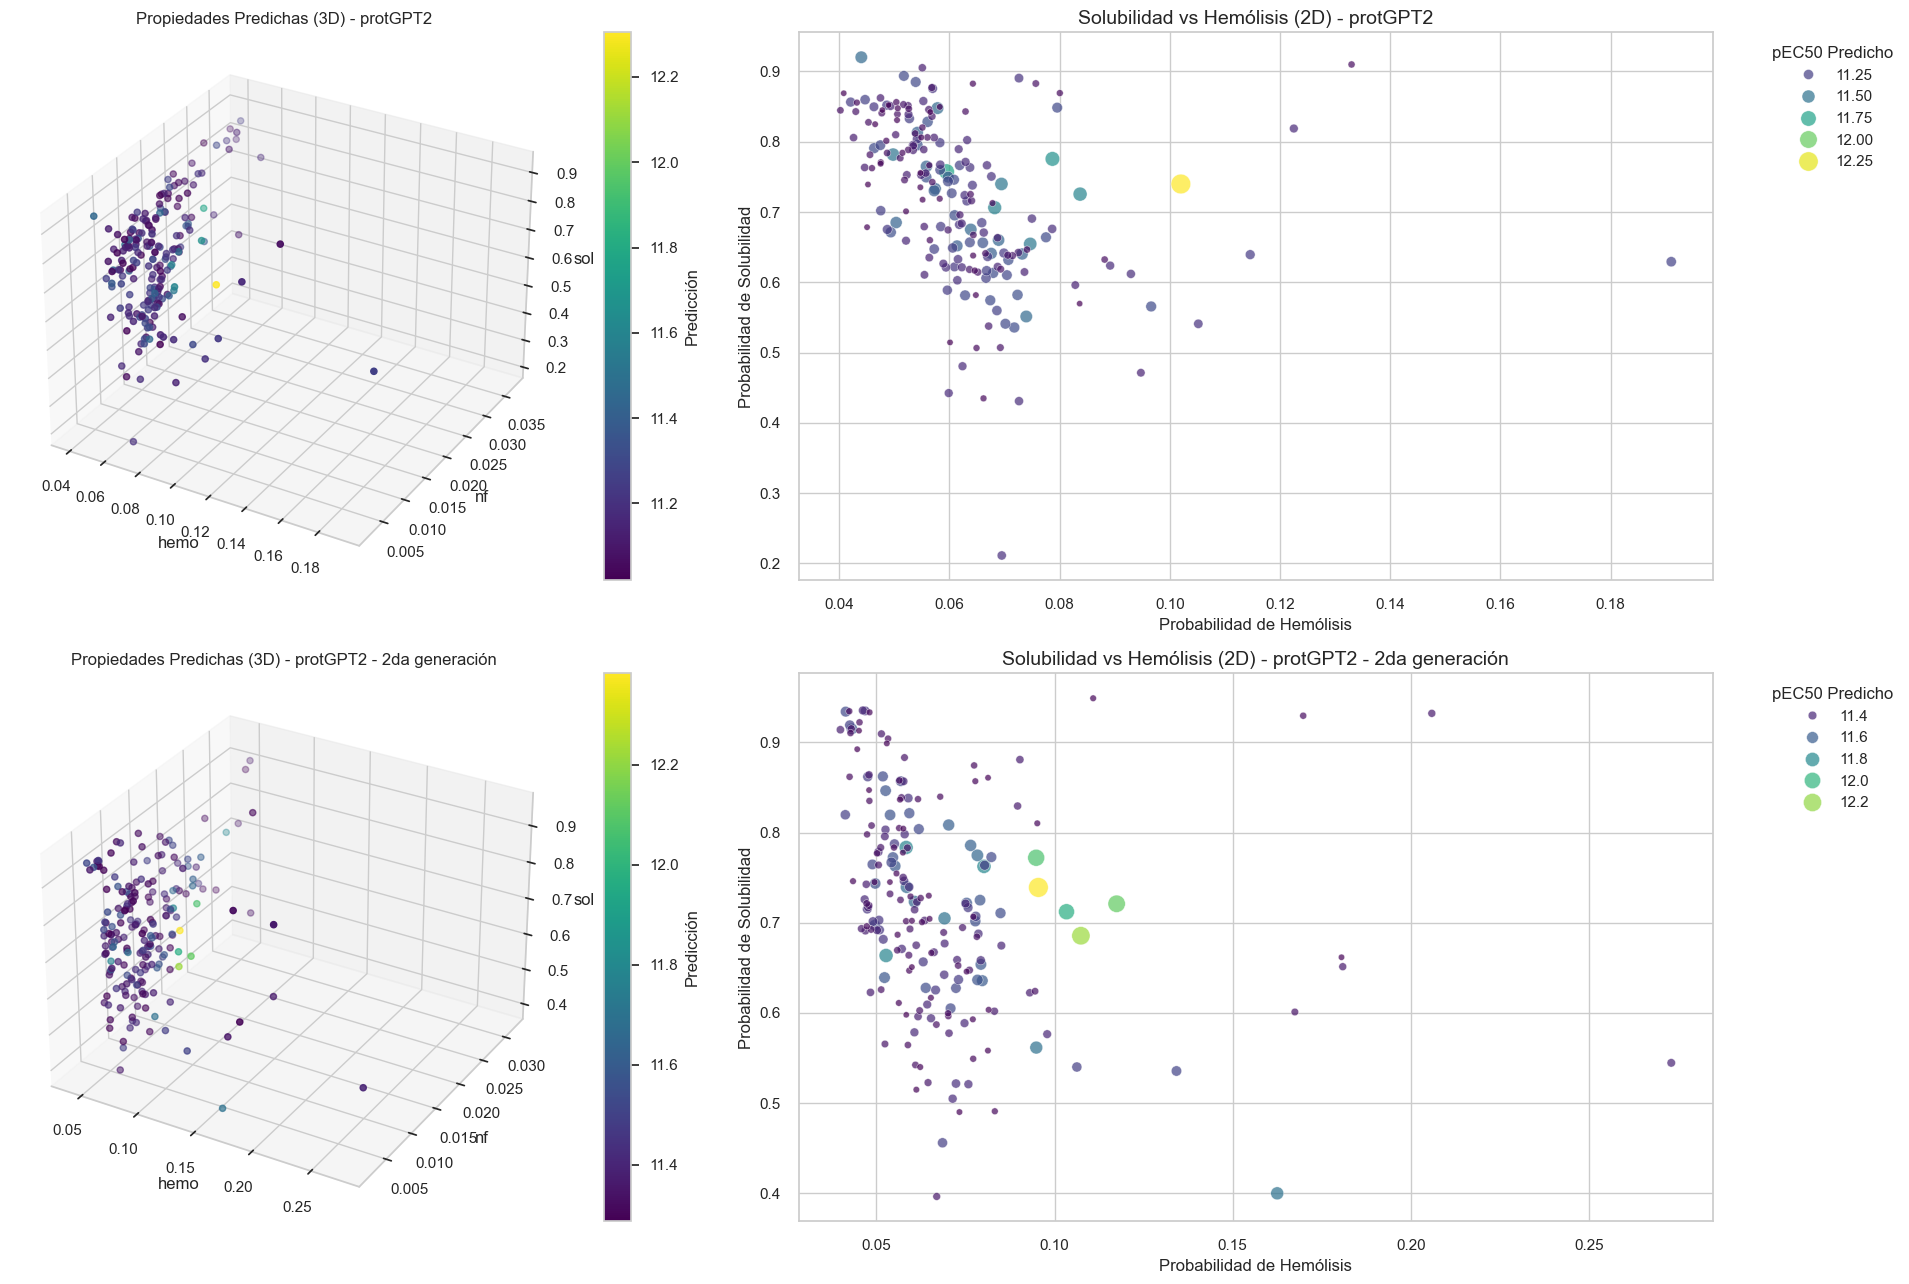

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Lista de dataframes y títulos para iterar (ajusta nombres)
datasets = [
    (df_secuencias_protGPT2, "protGPT2"),
    (df_secuencias_protGPT2_2d, "protGPT2 - 2da generación"),
]

# Crear figura con 3 filas y 2 columnas

fig = plt.figure(figsize=(21, 13))  # Ajustar tamaño si hace falta

for i, (df, titulo) in enumerate(datasets, start=1):
    # Subplot 3D
    ax3d = fig.add_subplot(len(datasets), 2, (i - 1) * 2 + 1, projection='3d')
    plot_pca_3d(
        df.head(200),
        pc_x='hemo',
        pc_y='nf',
        pc_z='sol',
        color_by='prediccion_-1pEC50',
        label='Predicción',
        ax=ax3d,
        cmap='viridis',
        title=f'Propiedades Predichas (3D) - {titulo}',
    )

    # Subplot 2D
    ax2d = fig.add_subplot(len(datasets), 2, (i - 1) * 2 + 2)
    scatter = sns.scatterplot(
        data=df.head(200),
        x='hemo',
        y='sol',
        hue='prediccion_-1pEC50',
        palette='viridis',
        size='prediccion_-1pEC50',
        sizes=(20, 200),
        alpha=0.7,
        edgecolor='w',
        ax=ax2d
    )
    
    ax2d.set_title(f'Solubilidad vs Hemólisis (2D) - {titulo}', fontsize=14)
    ax2d.set_xlabel('Probabilidad de Hemólisis', fontsize=12)
    ax2d.set_ylabel('Probabilidad de Solubilidad', fontsize=12)
    ax2d.grid(True)
    ax2d.legend(title='pEC50 Predicho', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [22]:
# guardar en un archivo CSV las nuevas secuencias generadas
nombre_archivo = f"secuencias_nuevas_prot_gpt2_{File_timestamp}"
nombre_archivo_csv = f"{nombre_archivo}.csv"

nombre_archivo_2d = f"secuencias_nuevas_prot_gpt2_2d_{File_timestamp}"
nombre_archivo_2d_csv = f"{nombre_archivo_2d}.csv"


# Guardar el DataFrame en CSV
df_secuencias_protGPT2.to_csv(Path(directorio_nuevas_secuencias /nombre_archivo_csv), index=False)
print(f"Archivo guardado: {Path(directorio_nuevas_secuencias /nombre_archivo_csv)}")

df_secuencias_protGPT2_2d.to_csv(Path(directorio_nuevas_secuencias /nombre_archivo_2d_csv), index=False)
print(f"Archivo guardado: {Path(directorio_nuevas_secuencias /nombre_archivo_2d_csv)}")

Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_6\secuencias_nuevas\secuencias_nuevas_prot_gpt2_20251102_135937.csv
Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_6\secuencias_nuevas\secuencias_nuevas_prot_gpt2_2d_20251102_135937.csv
Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_6\secuencias_nuevas\secuencias_nuevas_prot_gpt2_2d_20251102_135937.csv


## Generación de nuevas secuencias peptídicas agonistas de GLP-1 utilizando ProXLNET

In [23]:
# Generación de nuevas secuencias usando ProtXLNet
variants = generate_with_protxlnet_pipeline(
    ruta_modelo_protxlnet = directorio_modelos / "prot_xlnet_finetuned",
    prompt_sequences=prompt_sequences,
    num_variants_per_seq=2,
    num_return_sequences=2,
    max_length=longitud_maxima,
    min_length=longitud_minima,
    top_k=50,
    repetition_penalty=1.0,
)

variants_2d = generate_with_protxlnet_pipeline(
    ruta_modelo_protxlnet = directorio_modelos / "prot_xlnet_finetuned",
    prompt_sequences=variants,
    num_variants_per_seq=5,
    num_return_sequences=5,
    max_length=longitud_maxima,
    min_length=longitud_minima,
    top_k=50,
    repetition_penalty=1.0,
)

df_secuencias_protxlnet = pd.DataFrame(variants, columns=["sequence"])                    
df_secuencias_protxlnet['ID'] = [f"secuencia_protxlnet_{idx}" for idx in range(1, len(df_secuencias_protxlnet) + 1)]
df_secuencias_protxlnet = df_secuencias_protxlnet[['ID', 'sequence']]
display(df_secuencias_protxlnet.head(10))

df_secuencias_protxlnet_2d = pd.DataFrame(variants_2d, columns=["sequence"])                    
df_secuencias_protxlnet_2d['ID'] = [f"secuencia_protxlnet_2d_{idx}" for idx in range(1, len(df_secuencias_protxlnet_2d) + 1)]
df_secuencias_protxlnet_2d = df_secuencias_protxlnet_2d[['ID', 'sequence']]
display(df_secuencias_protxlnet_2d.head(10))



Usando dispositivo: cuda
Cargando tokenizer de ProtXLNet...
Cargando pipeline de generación...
Pipeline cargado.
Preparando las secuencias iniciales...
Pipeline cargado.
Preparando las secuencias iniciales...


  0%|          | 0/341 [00:00<?, ?it/s]

Generando 681 variantes (el pipeline manejará los lotes)...
Procesando salidas...
Procesando salidas...


Procesando:   0%|          | 0/681 [00:00<?, ?it/s]


Generación completada. Se obtuvieron 888 variantes únicas.
Usando dispositivo: cuda
Cargando tokenizer de ProtXLNet...
Cargando pipeline de generación...
Pipeline cargado.
Preparando las secuencias iniciales...
Pipeline cargado.
Preparando las secuencias iniciales...


  0%|          | 0/888 [00:00<?, ?it/s]

Generando 4422 variantes (el pipeline manejará los lotes)...
Procesando salidas...
Procesando salidas...


Procesando:   0%|          | 0/4422 [00:00<?, ?it/s]


Generación completada. Se obtuvieron 10527 variantes únicas.


,ID,sequence
0,secuencia_protxlnet_1,HSQGTFTSDYSKYLDEAAASDFVQWHVAGGHYGGYGYGGY
1,secuencia_protxlnet_2,YSEGTFTSDYSKLLERQAIDEFVNWLLMGGPSSGAQPPSPT
2,secuencia_protxlnet_3,YSEGTFASDYSKLLERQHIDEFVGGGGGGG
3,secuencia_protxlnet_4,HSQGTITSCCGCHGGG
4,secuencia_protxlnet_5,YSEGTFTSDLSILKEKEANREFVNWLLAGGPQSGAPPPS
5,secuencia_protxlnet_6,HSQCTFTSDYSKYGDGGCHHHHH
6,secuencia_protxlnet_7,YSEGTFTSDYSKWLG
7,secuencia_protxlnet_8,HSQGTFTSDYSLYCDSRRASEFVRAASEYVPRSHHHHH
8,secuencia_protxlnet_9,HSQGTFTSDYSKYLDSRCAAAFVQWWLNGGPSSGAPPPGCL
9,secuencia_protxlnet_10,YSQGTFTSWYSKYLEEEAVRLFIRWLLAGTSDYSKYLEE


,ID,sequence
0,secuencia_protxlnet_2d_1,YAEGTFTSDYSIYLLKQAAEAFVNGLLTGGPSSGAPPPSAE
1,secuencia_protxlnet_2d_2,HSPGTFTSGGHHRAGGHHAGC
2,secuencia_protxlnet_2d_3,YSEGTFTSDYLKLLEEAAVRDFIEWLLAGGPSMGAPPPSSD
3,secuencia_protxlnet_2d_4,HSQGTFWSDGHHPHGGGGGAGGG
4,secuencia_protxlnet_2d_5,HSQGGFTSDYFKYLDEAAASDFVQWLHHHHHHHHHH
5,secuencia_protxlnet_2d_6,YSEGTFTSDYSKLLEEEAVRDFIGWLLEGGPPSGAPPPSTE
6,secuencia_protxlnet_2d_7,YSEGEFTSDTWKLLEEECGGGGGGGGGGGGGG
7,secuencia_protxlnet_2d_8,HSQGTQTSAYSKYLGSRAASEFVQWRHGGGGGGGGGG
8,secuencia_protxlnet_2d_9,HSQGTFTSDYIKGGGGC
9,secuencia_protxlnet_2d_10,HACGTFTVDHHGGGGGGGHGGGGGGG


In [24]:
# guardar en un archivo CSV las nuevas secuencias generadas
nombre_archivo = f"secuencias_nuevas_protxlnet_{File_timestamp}"
nombre_archivo_csv = f"{nombre_archivo}.csv"

nombre_archivo_2d = f"secuencias_nuevas_protxlnet_2d_{File_timestamp}"
nombre_archivo_2d_csv = f"{nombre_archivo_2d}.csv"


# Guardar el DataFrame en CSV
df_secuencias_protxlnet.to_csv(Path(directorio_nuevas_secuencias /nombre_archivo_csv), index=False)
print(f"Archivo guardado: {Path(directorio_nuevas_secuencias /nombre_archivo_csv)}")

df_secuencias_protxlnet_2d.to_csv(Path(directorio_nuevas_secuencias /nombre_archivo_2d_csv), index=False)
print(f"Archivo guardado: {Path(directorio_nuevas_secuencias /nombre_archivo_2d_csv)}")


Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_6\secuencias_nuevas\secuencias_nuevas_protxlnet_20251102_135937.csv
Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_6\secuencias_nuevas\secuencias_nuevas_protxlnet_2d_20251102_135937.csv


In [25]:
# Cálculo de descriptores y actividad biológica predicha para las nuevas secuencias generadas con ProtXLNET

df_secuencias_protxlnet = calcular_descriptores_ifeature(
        directorio_temporal=directorio_temporal,
        dataframe=df_secuencias_protxlnet,
        sequence_col='sequence',
        id_col='ID',
        descriptores=descriptores,
        ifeatures_settings_json=ifeatures_settings_json
    )
    
# Calculo de pEC50 sobre los datos de alpha fold y uniprot
df_secuencias_protxlnet = predict_model(modelo_pycaret, data=df_secuencias_protxlnet)
df_secuencias_protxlnet.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
# Predicciones con PeptideBert para el conjunto obtenido de la base de datos de Aphafold
df_secuencias_protxlnet = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_secuencias_protxlnet, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)

df_secuencias_protxlnet_2d = calcular_descriptores_ifeature(
        directorio_temporal=directorio_temporal,
        dataframe=df_secuencias_protxlnet_2d,
        sequence_col='sequence',
        id_col='ID',
        descriptores=descriptores,
        ifeatures_settings_json=ifeatures_settings_json
    )
    
# Calculo de pEC50 sobre los datos de alpha fold y uniprot
df_secuencias_protxlnet_2d = predict_model(modelo_pycaret, data=df_secuencias_protxlnet_2d)
df_secuencias_protxlnet_2d.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
# Predicciones con PeptideBert para el conjunto obtenido de la base de datos de Aphafold
df_secuencias_protxlnet_2d = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_secuencias_protxlnet_2d, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)



Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_142553.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_142553.fasta...
  - OK! File is structurally valid. Found 888 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_142553.fasta' es válido. Se encontraron 888 registros.
Iniciando cálculo de 14 descriptores...


calculando descriptores:   0%|          | 0/14 [00:00<?, ?it/s]

File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
Cálculo de descriptores finalizado.
Descriptores unidos al DataFrame. Forma final: (888, 1292)
Archivo temporal 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_142553.fasta' eliminado.
Cálculo de descriptores finalizado.
Descriptores unido

  0%|          | 0/888 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/888 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/888 [00:00<?, ?it/s]

Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_142646.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_142646.fasta...
  - OK! File is structurally valid. Found 10527 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_142646.fasta' es válido. Se encontraron 10527 registros.
Iniciando cálculo de 14 descriptores...


calculando descriptores:   0%|          | 0/14 [00:00<?, ?it/s]

File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
Cálculo de descriptores finalizado.
Descriptores unidos al DataFrame. Forma final: (10527, 1292)
Archivo temporal 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251102_142646.fasta' eliminado.
Cálculo de descriptores 

  0%|          | 0/10527 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/10527 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/10527 [00:00<?, ?it/s]

In [66]:
#Top  de secuencias generadas por propiedades deseadas 
df_secuencias_protxlnet.sort_values(by=['prediccion_-1pEC50','sol','hemo','nf'], ascending=[False, False, True, True], inplace=True)
display(df_secuencias_protxlnet[["ID","sequence","sol","hemo", "nf","prediccion_-1pEC50"]].head(20))

#Top  de secuencias generadas por propiedades deseadas 
df_secuencias_protxlnet_2d.sort_values(by=['prediccion_-1pEC50','sol','hemo','nf'], ascending=[False, False, True, True], inplace=True)
display(df_secuencias_protxlnet_2d[["ID","sequence","sol","hemo", "nf","prediccion_-1pEC50"]].head(20))

,ID,sequence,sol,hemo,nf,prediccion_-1pEC50
329,secuencia_protxlnet_330,HSQGTFTSDYSRYLDSRRASEFVDYGSRIGLGVGLGVGLGV,0.739944,0.072404,0.007979,12.387604
738,secuencia_protxlnet_739,YSEGTFTSDYSKLLEEAAVRDFIEWYLAGGPSSGAPPPSAA,0.584547,0.064195,0.009408,11.898814
513,secuencia_protxlnet_514,YSEGTFTGDLGVDVGMGRNVGGHH,0.823922,0.070824,0.079499,11.754509
30,secuencia_protxlnet_31,HSQGTFYSDYSKYLDSRAASEFVQWLISEG,0.781642,0.065546,0.013881,11.735253
729,secuencia_protxlnet_730,YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSSNAPP,0.653375,0.069393,0.012029,11.613167
505,secuencia_protxlnet_506,YSEGTFTSDYSKLKEEEAVRLFIEWLLEGGPSSGAPPPSAL,0.688019,0.072075,0.007610,11.534083
439,secuencia_protxlnet_440,SADGTFTSDVSAYLKEQAIKDFVAKLKAGQDFVAKAKAGQDVVV,0.929790,0.039490,0.004861,11.510065
295,secuencia_protxlnet_296,YSEGTFTSDYSKLLEGEMVRDFIEWLLAGGPSSGAPPPSGG,0.713605,0.071451,0.013533,11.509522
884,secuencia_protxlnet_885,HSQGTFTSDYSKYLGSRAAACFVQWLLNGGWSSGAPPCGGD,0.831571,0.056197,0.011141,11.491838
818,secuencia_protxlnet_819,YSEGTFTSDYSKLLEGEAVRDFIEWLLAGGPSSGAPPPSCG,0.719032,0.074814,0.010093,11.487221


,ID,sequence,sol,hemo,nf,prediccion_-1pEC50
9318,secuencia_protxlnet_2d_9319,HSQGTFTSDYSRYLDSRRASEFVDYGSRIGLGVGLPVGLGV,0.736581,0.068834,0.008569,12.372167
10123,secuencia_protxlnet_2d_10124,HSQGLFTSDYSRYLDSRRASEFVDYGSRIGLGVGLGVGLGV,0.715279,0.078117,0.006449,12.345046
7435,secuencia_protxlnet_2d_7436,HSQGTFTSDYSRYLDSRRASEFVDYGSRIGLGVGLGYGLGV,0.721780,0.070037,0.008429,12.093665
5524,secuencia_protxlnet_2d_5525,YSEGTFTSDYSKLLEEAAVRDFIEWYLAGGLSSGAPPPSAA,0.528298,0.072895,0.006447,11.826689
3156,secuencia_protxlnet_2d_3157,HSQGTFTSDYSKYLHSRVASDFVQWLVGGG,0.856442,0.063904,0.016664,11.822016
2197,secuencia_protxlnet_2d_2198,YSEGTFTTDYSKLLEEAAVRDFIEWYLAGGPSSGAPPPSAA,0.577923,0.064452,0.009189,11.706832
10262,secuencia_protxlnet_2d_10263,YSERTFTSDYSKLLEEAAVRDFIEWYLAGGPSSGAPPPSAA,0.524164,0.063930,0.008022,11.705555
604,secuencia_protxlnet_2d_605,HSQGTFTSDYSKYLHSRVASDFVQWLVGG,0.829898,0.061606,0.015379,11.702967
9120,secuencia_protxlnet_2d_9121,ETDGTFTSDVSAYLNERAVG,0.792982,0.064746,0.121296,11.651766
6071,secuencia_protxlnet_2d_6072,HSQGTFTSDYSKYLDSRRASEFVFWLIAGG,0.740188,0.068787,0.010389,11.636016


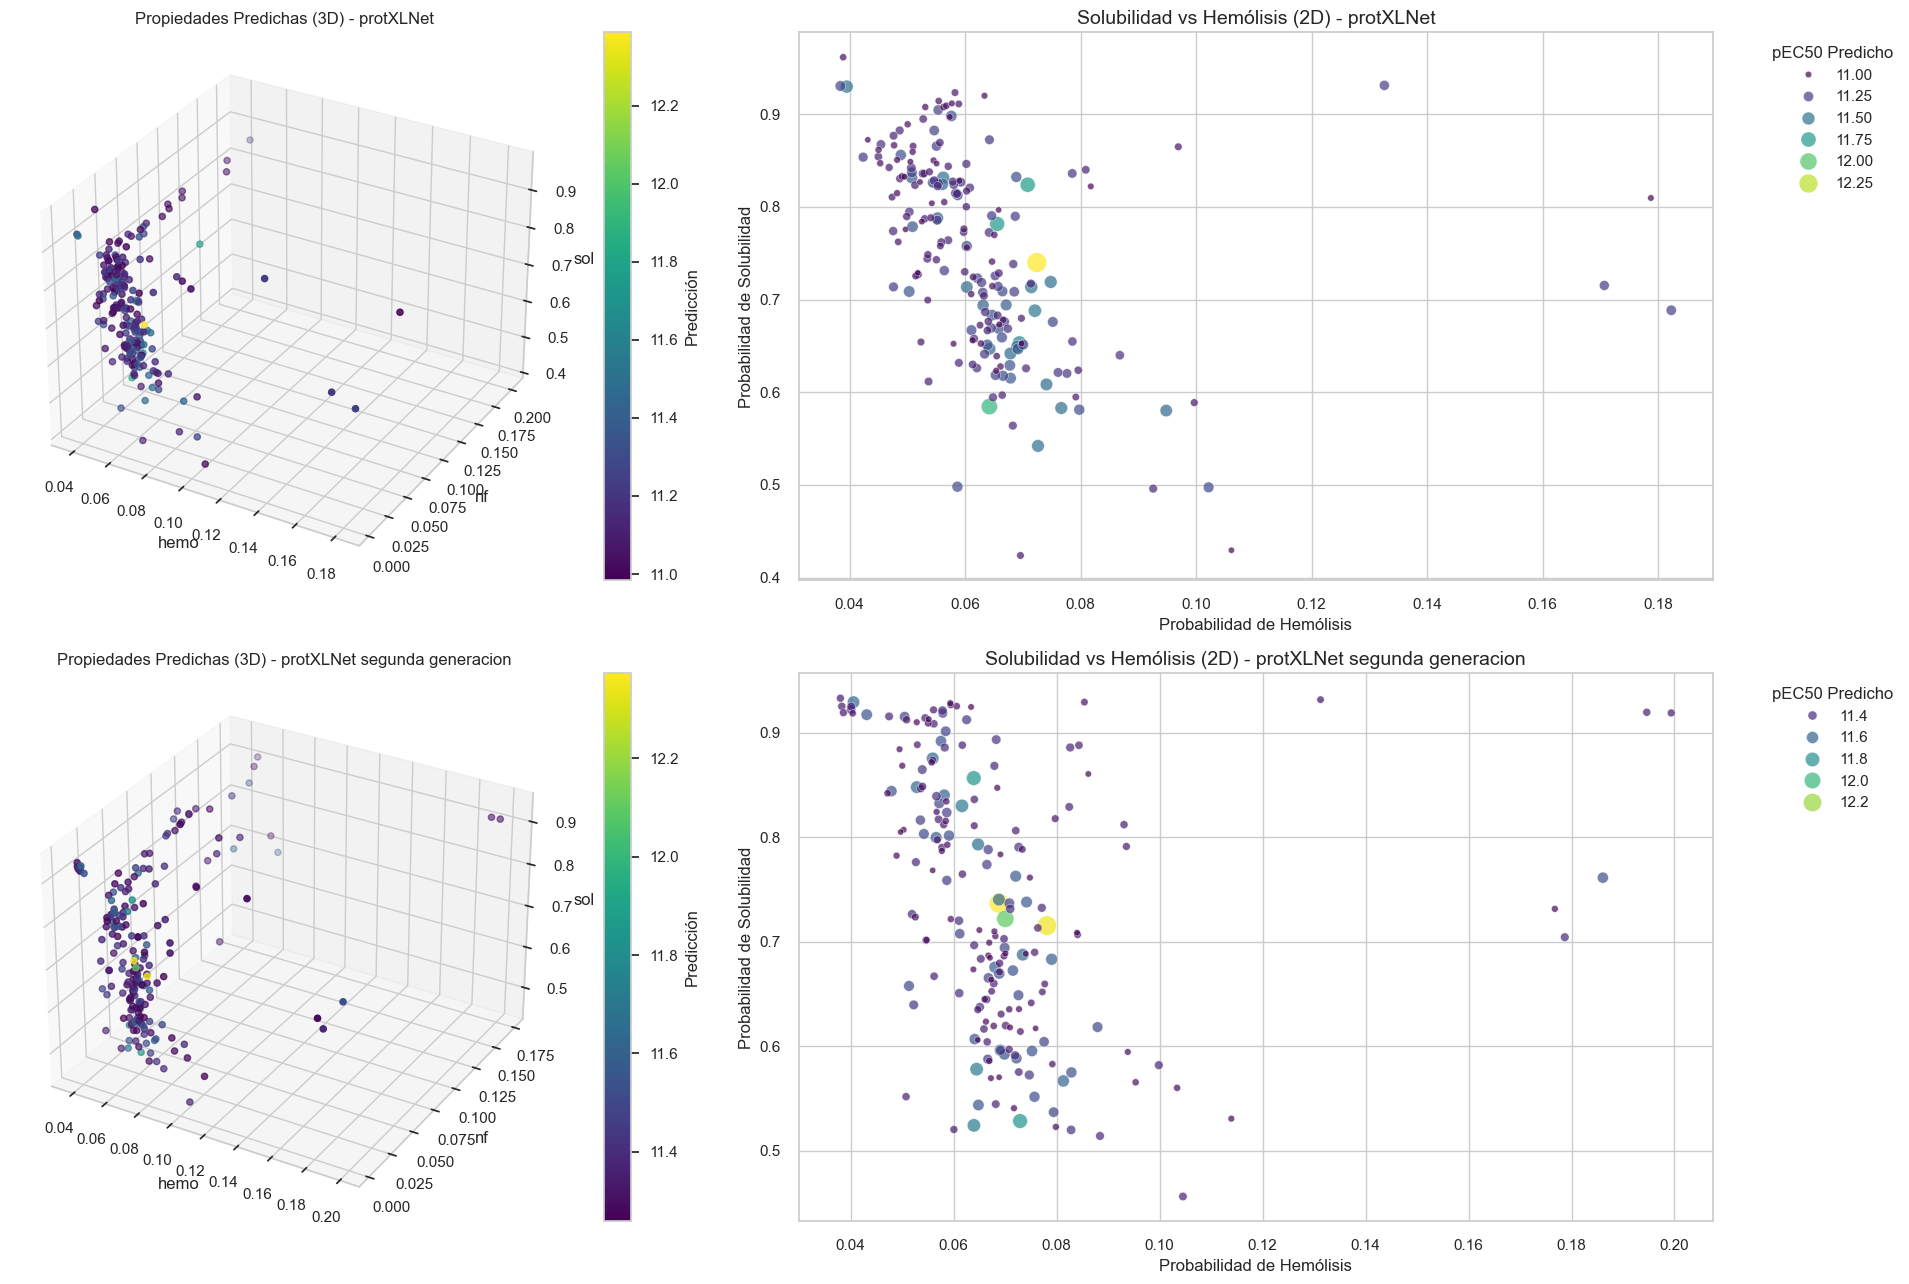

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Lista de dataframes y títulos para iterar (ajusta nombres)
datasets = [
    (df_secuencias_protxlnet, "protXLNet"),
    (df_secuencias_protxlnet_2d, "protXLNet segunda generacion"),
]

# Crear figura con 3 filas y 2 columnas

fig = plt.figure(figsize=(21, 13))  # Ajustar tamaño si hace falta

for i, (df, titulo) in enumerate(datasets, start=1):
    # Subplot 3D
    ax3d = fig.add_subplot(len(datasets), 2, (i - 1) * 2 + 1, projection='3d')
    plot_pca_3d(
        df.head(200),
        pc_x='hemo',
        pc_y='nf',
        pc_z='sol',
        color_by='prediccion_-1pEC50',
        label='Predicción',
        ax=ax3d,
        cmap='viridis',
        title=f'Propiedades Predichas (3D) - {titulo}',
    )

    # Subplot 2D
    ax2d = fig.add_subplot(len(datasets), 2, (i - 1) * 2 + 2)
    scatter = sns.scatterplot(
        data=df.head(200),
        x='hemo',
        y='sol',
        hue='prediccion_-1pEC50',
        palette='viridis',
        size='prediccion_-1pEC50',
        sizes=(20, 200),
        alpha=0.7,
        edgecolor='w',
        ax=ax2d
    )
    
    ax2d.set_title(f'Solubilidad vs Hemólisis (2D) - {titulo}', fontsize=14)
    ax2d.set_xlabel('Probabilidad de Hemólisis', fontsize=12)
    ax2d.set_ylabel('Probabilidad de Solubilidad', fontsize=12)
    ax2d.grid(True)
    ax2d.legend(title='pEC50 Predicho', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [28]:
# guardar en un archivo CSV las nuevas secuencias generadas
nombre_archivo = f"secuencias_nuevas_protxlnet_{File_timestamp}"
nombre_archivo_csv = f"{nombre_archivo}.csv"

nombre_archivo_2d = f"secuencias_nuevas_protxlnet_2d_{File_timestamp}"
nombre_archivo_2d_csv = f"{nombre_archivo_2d}.csv"


# Guardar el DataFrame en CSV
df_secuencias_protxlnet.to_csv(Path(directorio_nuevas_secuencias /nombre_archivo_csv), index=False)
print(f"Archivo guardado: {Path(directorio_nuevas_secuencias /nombre_archivo_csv)}")

df_secuencias_protxlnet_2d.to_csv(Path(directorio_nuevas_secuencias /nombre_archivo_2d_csv), index=False)
print(f"Archivo guardado: {Path(directorio_nuevas_secuencias /nombre_archivo_2d_csv)}")


Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_6\secuencias_nuevas\secuencias_nuevas_protxlnet_20251102_135937.csv
Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_6\secuencias_nuevas\secuencias_nuevas_protxlnet_2d_20251102_135937.csv
Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_6\secuencias_nuevas\secuencias_nuevas_protxlnet_2d_20251102_135937.csv


In [35]:
df_combined


,ID,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,sequence,Species,organismCommonNames,prediccion_-1pEC50,hemo,sol,nf,EC50_T2,EC50_LOG_T2,-1pEC50
0,sp-P01275-GLUC_HUMAN,0.133333,0.00,0.033333,0.100000,0.066667,0.100000,0.033333,0.033333,0.066667,...,HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR,Pan troglodytes,Chimpanzee,10.234846,0.066893,0.825296,0.009175,NaN,NaN,NaN
1,seq_pep1,0.033333,0.00,0.100000,0.100000,0.066667,0.066667,0.033333,0.000000,0.033333,...,HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE,NaN,NaN,9.256478,0.055827,0.849804,0.034196,563.00,-9.25,9.249492
2,seq_pep2,0.033333,0.00,0.100000,0.100000,0.066667,0.066667,0.033333,0.000000,0.033333,...,HSQGTFTSDYSKYLDSRRAEDFVQWLENGE,NaN,NaN,9.328444,0.052318,0.845523,0.031188,552.00,-9.26,9.258060
3,seq_pep3,0.034483,0.00,0.103448,0.068966,0.068966,0.034483,0.034483,0.000000,0.034483,...,HSQGTFTSDYSKYLDSRRAEDFVQWLENT,NaN,NaN,9.321180,0.052129,0.786436,0.027671,252.00,-9.60,9.598599
4,seq_pep4,0.055556,0.00,0.083333,0.027778,0.055556,0.166667,0.027778,0.000000,0.027778,...,HSQGTFTSDYSKYLDSRRAEDFVQWLVAGGSGSGSG,NaN,NaN,11.209304,0.055343,0.843368,0.028107,6.03,-11.22,11.219683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614,secuencia_1592,0.073171,0.00,0.024390,0.121951,0.048780,0.121951,0.000000,0.000000,0.048780,...,YSEGTFTSDYSKLKEEEANRLFGEWLLAGGPSSGAPPPSPN,NaN,NaN,11.100747,0.053777,0.761195,0.024900,NaN,NaN,NaN
2615,secuencia_1593,0.170732,0.00,0.048780,0.073171,0.048780,0.121951,0.000000,0.024390,0.024390,...,YAEGTFTSDYSIYLDKQAAEAFVNGLLAGGPSSGAPPPSAE,NaN,NaN,11.001755,0.060259,0.586709,0.012703,NaN,NaN,NaN
2616,secuencia_1594,0.121951,0.00,0.073171,0.073171,0.048780,0.073171,0.000000,0.024390,0.000000,...,YAEGTFTSDYSIYLDEQAAQEFVNWLLANGPSSGAPPPSDY,NaN,NaN,9.974996,0.058036,0.535198,0.011470,NaN,NaN,NaN
2617,secuencia_1595,0.000000,0.00,0.000000,0.000000,0.047619,0.142857,0.047619,0.000000,0.000000,...,HSQGTFTSSYSGNQSGQTNTT,NaN,NaN,8.146158,0.050894,0.882192,0.341142,NaN,NaN,NaN


## Resultado final de la combinación de secuencias generadas por ambos modelos
Después de generar nuevas secuencias peptídicas agonistas de GLP-1 utilizando ambos modelos (ProtGPT2 y ProXLNET), se combinaron las secuencias generadas en un solo conjunto de datos. Se eliminaron las secuencias duplicadas para asegurar la diversidad del conjunto final. Posteriormente, se ordenaron las secuencias según las características deseadas, priorizando aquellas con mayor actividad biológica predicha (-1pEC50), mayor solubilidad, menor hemoliticidad y menor toxicidad.

In [48]:
# Unir todos los dataframes generados y existentes
df_all_sequences = pd.concat([
    df_combined,
    df_secuencias_protxlnet,
    df_secuencias_protxlnet_2d,
    df_secuencias_protGPT2,
    df_secuencias_protGPT2_2d
], ignore_index=True)

print(f"Total de secuencias antes de eliminar duplicados: {len(df_all_sequences)}")

# Eliminar duplicados basándose en la columna 'sequence'
df_all_sequences = df_all_sequences.drop_duplicates(subset=['sequence'], keep='first')

print(f"Total de secuencias después de eliminar duplicados: {len(df_all_sequences)}")

# # Ordenar por las características deseadas
# df_all_sequences = df_all_sequences.sort_values(
#     by=['prediccion_-1pEC50', 'sol', 'hemo', 'nf'], 
#     ascending=[False, False, True, True],inplace=True
# )

df_all_sequences.sort_values(
     by=['prediccion_-1pEC50', 'sol', 'hemo', 'nf'], 
     ascending=[False, False, True, True],inplace=True
)

Total de secuencias antes de eliminar duplicados: 32218
Total de secuencias después de eliminar duplicados: 32216
Total de secuencias después de eliminar duplicados: 32216


### Top 20 secuencias peptídicas agonistas de GLP-1 generadas
A continuación, se presentan las 20 mejores secuencias peptídicas agonistas de GLP-1 generadas, junto con sus características predichas:    

In [73]:
df_all_sequences[["ID","Description","sequence","sol","hemo", "nf", "prediccion_-1pEC50"]].head(20)

,ID,Description,sequence,sol,hemo,nf,prediccion_-1pEC50
1961,secuencia_protxlnet_330,NaN,HSQGTFTSDYSRYLDSRRASEFVDYGSRIGLGVGLGVGLGV,0.739944,0.072404,0.007979,12.387604
14658,secuencia_protgpt2_2g_15073,NaN,YEEGTFTGDLGVDVGMGGNVGGSGLTVGANVGLGLGTNVGLGID,0.739177,0.095478,0.009071,12.382325
2849,secuencia_protxlnet_2d_9319,NaN,HSQGTFTSDYSRYLDSRRASEFVDYGSRIGLGVGLPVGLGV,0.736581,0.068834,0.008569,12.372167
2850,secuencia_protxlnet_2d_10124,NaN,HSQGLFTSDYSRYLDSRRASEFVDYGSRIGLGVGLGVGLGV,0.715279,0.078117,0.006449,12.345046
13376,secuencia_protgpt2_1061,NaN,YEEGTFTGDLGVDVGMGGNVGGSGLTVGATVGLGLGTNVGLGID,0.739904,0.102000,0.008634,12.304538
14659,secuencia_protgpt2_2g_768,NaN,YEEGTFTGDLIVDVGMGGNVGGSGLTVGATVGLGLGTNVGLGID,0.685599,0.107410,0.006364,12.218304
14660,secuencia_protgpt2_2g_10381,NaN,YEEGTFTGDLGVDVGMGGLVGGSGLTVGATVGLGLGTNVGLGID,0.721087,0.117439,0.006521,12.115181
2851,secuencia_protxlnet_2d_7436,NaN,HSQGTFTSDYSRYLDSRRASEFVDYGSRIGLGVGLGYGLGV,0.721780,0.070037,0.008429,12.093665
14661,secuencia_protgpt2_2g_12830,NaN,YEEGTFTGDLGVDVGMGGNVGGSGLTVGATVGLGLGTNVGLGDD,0.772126,0.094860,0.012342,12.069438
14662,secuencia_protgpt2_2g_10027,NaN,YEEGTFTGDLGVDVGMGGNVGGSGLTVGATVGLGLGTNVGLGIM,0.712225,0.103368,0.007157,11.968643


### Visualización de los resultados finales
Se utilizaron gráficos de distribución y gráficos ordenados para visualizar las características de las secuencias

In [47]:
# guardar en un archivo CSV las nuevas secuencias generadas
nombre_archivo = f"secuencias_concentrado_{File_timestamp}"
nombre_archivo_csv = f"{nombre_archivo}.csv"


# Guardar el DataFrame en CSV
df_all_sequences.to_csv(Path(directorio_nuevas_secuencias /nombre_archivo_csv), index=False)
print(f"Archivo guardado: {Path(directorio_nuevas_secuencias /nombre_archivo_csv)}")


Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_6\secuencias_nuevas\secuencias_concentrado_20251102_135937.csv


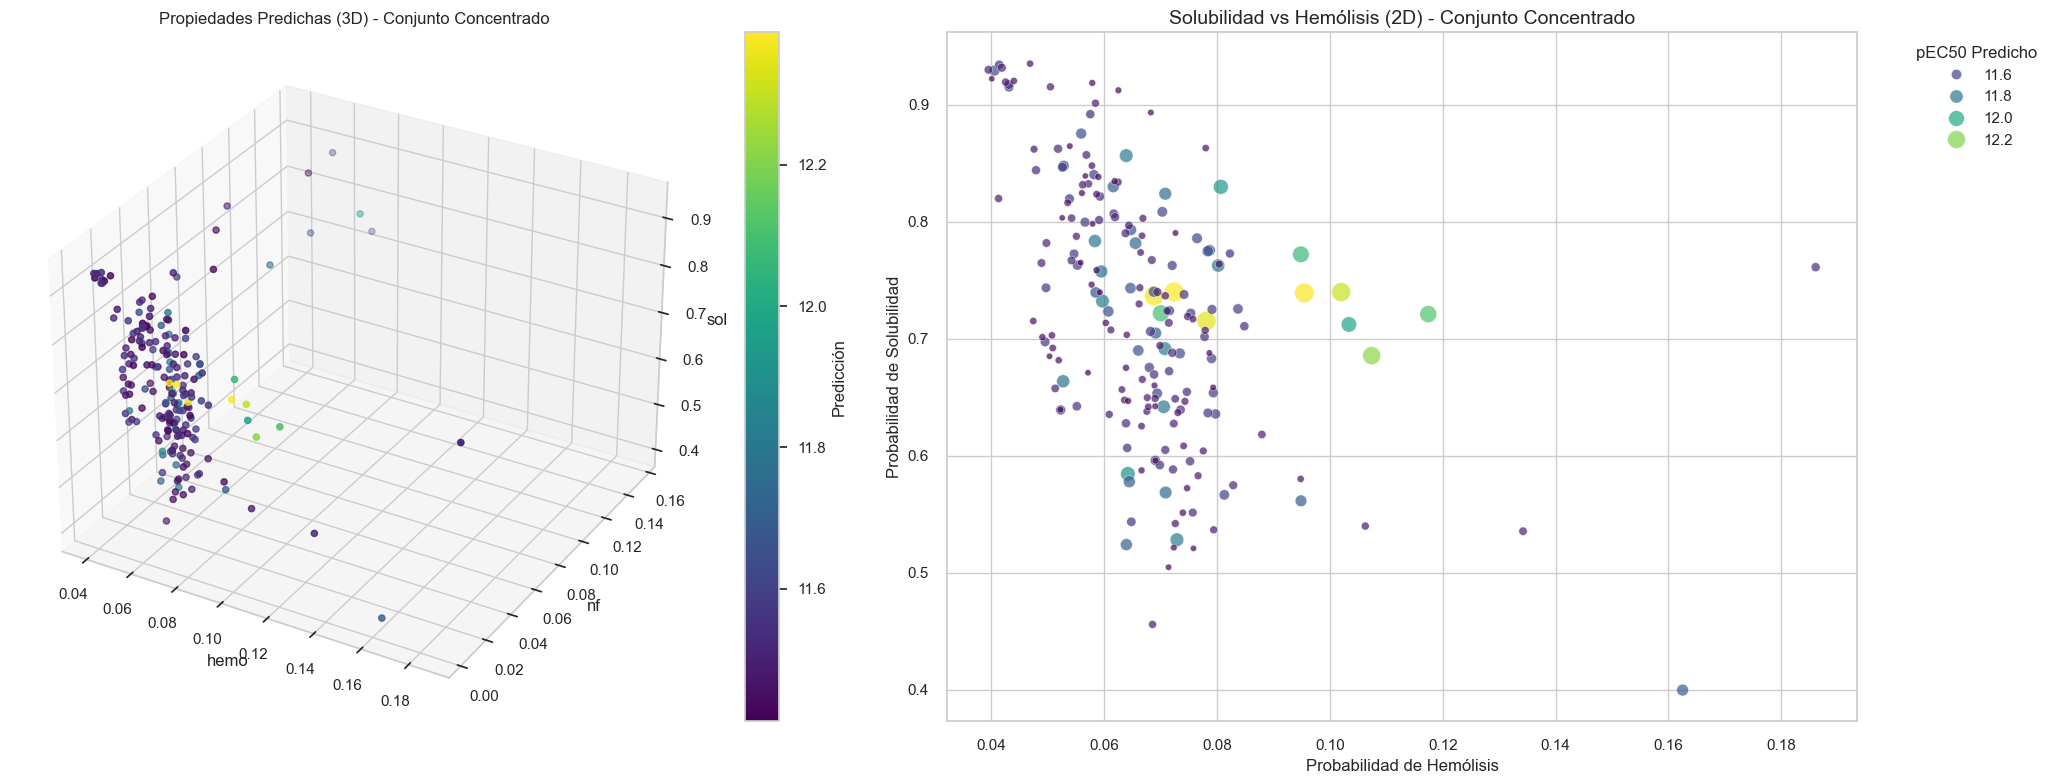

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Lista de dataframes y títulos para iterar (ajusta nombres)
datasets = [
    # (df_secuencias_protGPT2, "protGPT2"),
    # (df_secuencias_protGPT2_2d, "protGPT2 - 2da generación"),
    # (df_secuencias_protxlnet, "protXLNet"),
    # (df_secuencias_protxlnet_2d, "protXLNet segunda generacion"),
    (df_all_sequences, "Conjunto Concentrado")
]

# Crear figura con 3 filas y 2 columnas

fig = plt.figure(figsize=(21, 8))  # Ajustar tamaño si hace falta

for i, (df, titulo) in enumerate(datasets, start=1):
    # Subplot 3D
    ax3d = fig.add_subplot(len(datasets), 2, (i - 1) * 2 + 1, projection='3d')
    plot_pca_3d(
        df.head(200),
        pc_x='hemo',
        pc_y='nf',
        pc_z='sol',
        color_by='prediccion_-1pEC50',
        label='Predicción',
        ax=ax3d,
        cmap='viridis',
        title=f'Propiedades Predichas (3D) - {titulo}',
    )

    # Subplot 2D
    ax2d = fig.add_subplot(len(datasets), 2, (i - 1) * 2 + 2)
    scatter = sns.scatterplot(
        data=df.head(200),
        x='hemo',
        y='sol',
        hue='prediccion_-1pEC50',
        palette='viridis',
        size='prediccion_-1pEC50',
        sizes=(20, 200),
        alpha=0.7,
        edgecolor='w',
        ax=ax2d
    )
    
    ax2d.set_title(f'Solubilidad vs Hemólisis (2D) - {titulo}', fontsize=14)
    ax2d.set_xlabel('Probabilidad de Hemólisis', fontsize=12)
    ax2d.set_ylabel('Probabilidad de Solubilidad', fontsize=12)
    ax2d.grid(True)
    ax2d.legend(title='pEC50 Predicho', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


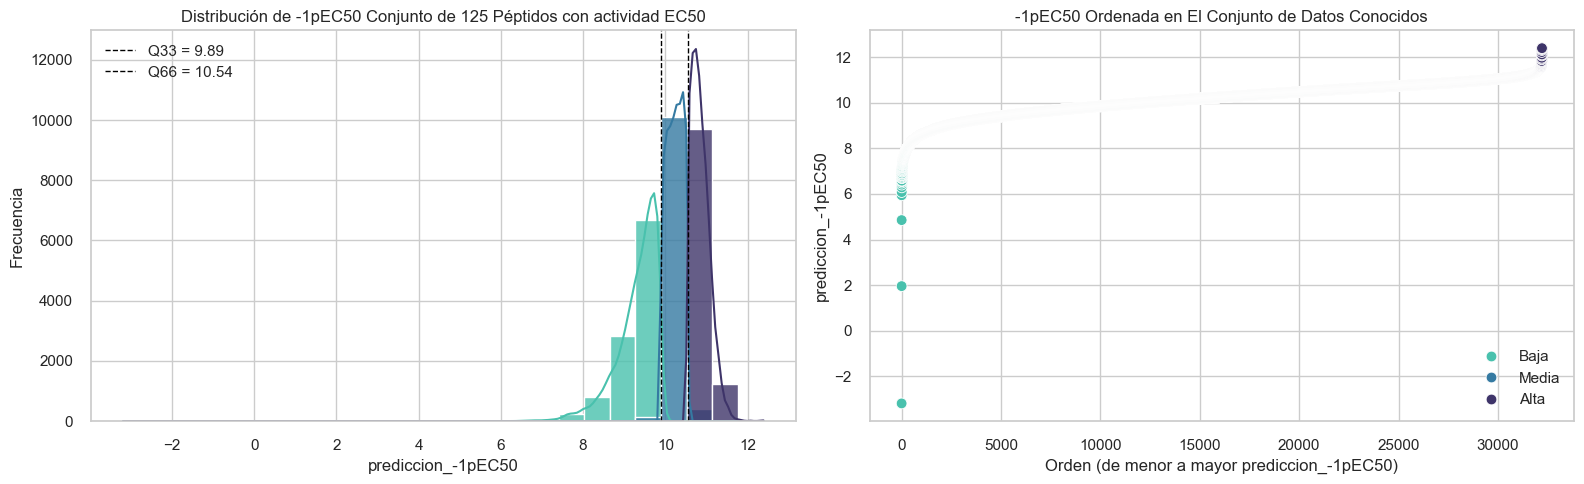


Resumen por categoría:
              n   promedio        min        max
Potencia                                        
Alta      10954  10.859681  10.540980  12.387604
Baja      10631   9.305159  -3.185742   9.887093
Media     10631  10.227666   9.887168  10.540942


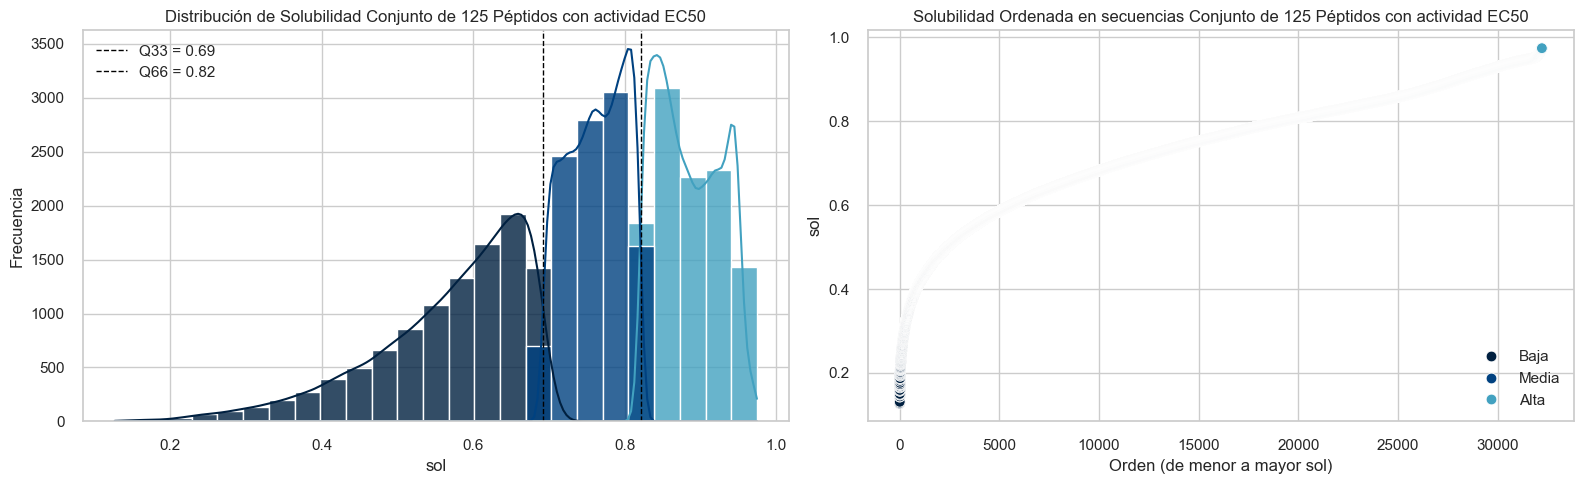


Resumen por categoría:
              n  promedio       min       max
Potencia                                     
Alta      10954  0.884724  0.820778  0.974296
Baja      10631  0.567427  0.126858  0.692376
Media     10631  0.761403  0.692398  0.820775


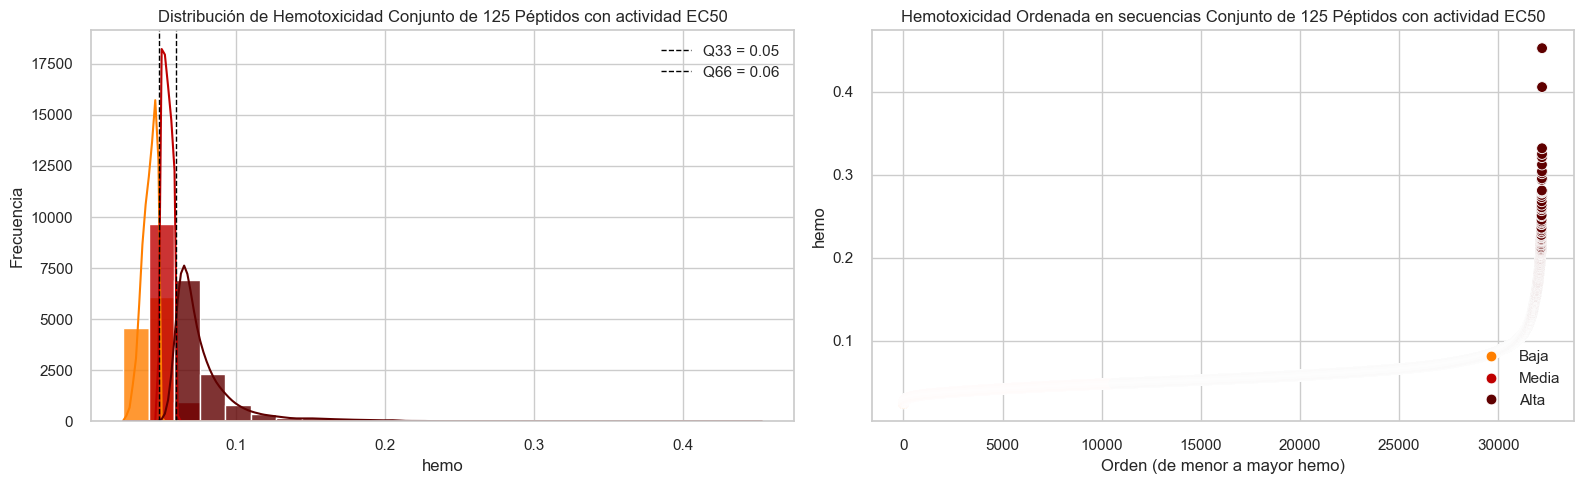


Resumen por categoría:
              n  promedio       min       max
Potencia                                     
Alta      10954  0.079286  0.059954  0.452596
Baja      10631  0.041835  0.024391  0.048543
Media     10631  0.053855  0.048543  0.059950


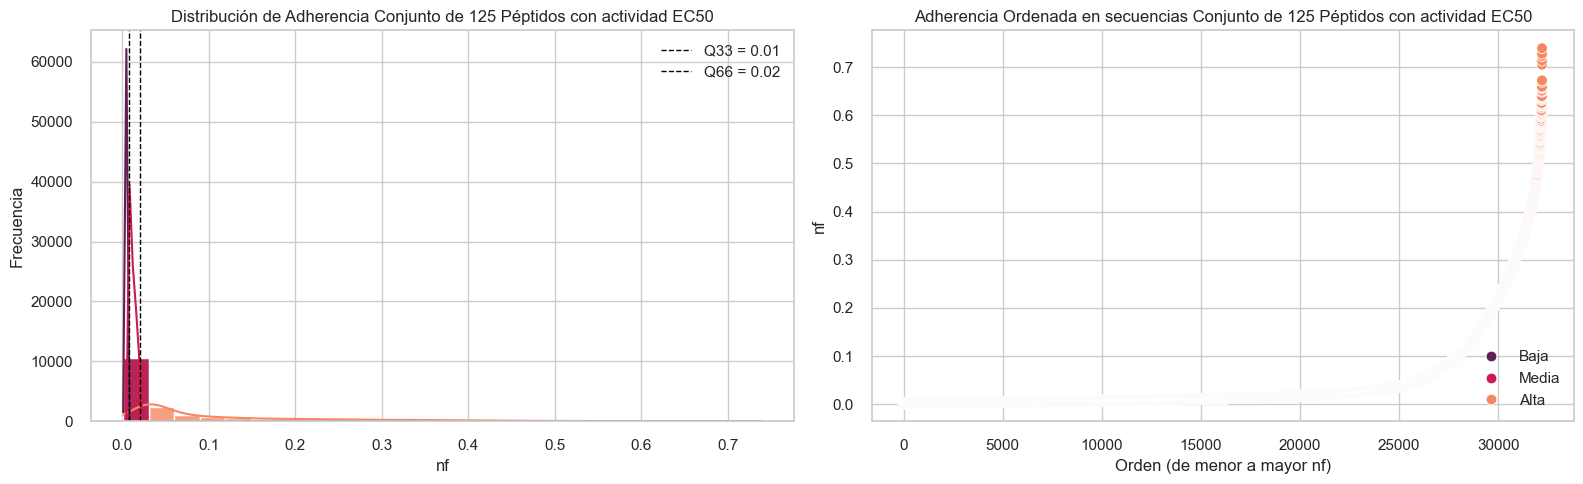


Resumen por categoría:
              n  promedio       min       max
Potencia                                     
Alta      10954  0.124739  0.020293  0.739300
Baja      10631  0.004827  0.001266  0.007716
Media     10631  0.012616  0.007716  0.020293


In [72]:
from src.plotting import clasificar_y_graficar_cuantiles
%matplotlib inline 
clasificar_y_graficar_cuantiles(
    df_input=df_all_sequences,   columna_valor='prediccion_-1pEC50',
    columna_id='ID', top_n=15,palette='mako_r',mostrar_top=False,
    titulo_distribucion='Distribución de -1pEC50 Conjunto de 125 Péptidos con actividad EC50',
    titulo_ordenado='-1pEC50 Ordenada en El Conjunto de Datos Conocidos')
  
    
clasificar_y_graficar_cuantiles(
    df_input=df_all_sequences,   columna_valor='sol', 
    columna_id='ID', top_n=15,palette='ocean',mostrar_top=False,
    titulo_distribucion='Distribución de Solubilidad Conjunto de 125 Péptidos con actividad EC50',
    titulo_ordenado='Solubilidad Ordenada en secuencias Conjunto de 125 Péptidos con actividad EC50'
)    

clasificar_y_graficar_cuantiles(
    df_input=df_all_sequences,   columna_valor='hemo', 
    columna_id='ID', top_n=15,palette='gist_heat_r',mostrar_top=False,
    titulo_distribucion='Distribución de Hemotoxicidad Conjunto de 125 Péptidos con actividad EC50',
    titulo_ordenado='Hemotoxicidad Ordenada en secuencias Conjunto de 125 Péptidos con actividad EC50'
)

clasificar_y_graficar_cuantiles(
    df_input=df_all_sequences,   columna_valor='nf', 
    columna_id='ID', top_n=15, palette='rocket',mostrar_top=False,
    titulo_distribucion='Distribución de Adherencia Conjunto de 125 Péptidos con actividad EC50',
    titulo_ordenado='Adherencia Ordenada en secuencias Conjunto de 125 Péptidos con actividad EC50'
)

# Analisis de las secuencias generadas usando AlphaFold2-multimer
Se utilizó AlphaFold-multimer para predecir la estructura tridimensional de las nuevas secuencias peptídicas generadas en complejo con el receptor GLP-1R. Se analizaron las estructuras predichas para evaluar la calidad del plegamiento y la interacción con el receptor, utilizando métricas como el pLDDT y el PAE.

ID	| sequence	| sol | 	hemo| 	nf	| prediccion_-1pEC50	| 
---	| ---	| ---	| ---	| ---	| ---	|
sp-P01275-GLUC_HUMAN |	HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR	|0.825296	|0.066893	|0.009175	|10.234846	|

<img src="Pictures/sp-P01275-GLUC_HUMAN.png" width= 40% height= 40%  />
<img src="Pictures/dock_sp-P01275-GLUC_HUMAN.png" width= 40% height= 40% />

ID	| sequence	| sol | 	hemo| 	nf	| prediccion_-1pEC50	| 
---	| ---	| ---	| ---	| ---	| ---	|
secuencia_protxlnet_330	| HSQGTFTSDYSRYLDSRRASEFVDYGSRIGLGVGLGVGLGV	| 0.739944	| 0.072404	| 0.007979	| 12.387604	|

<img src="Pictures/secuencia_protxlnet_330.png" width= 30% height= 30% />
<img src="Pictures/dock_secuencia_protxlnet_330.png" width= 30% height= 30% />


ID	| sequence	| sol | 	hemo| 	nf	| prediccion_-1pEC50	| 
---	| ---	| ---	| ---	| ---	| ---	|
secuencia_protgpt2_2g_15073| YEEGTFTGDLGVDVGMGGNVGGSGLTVGANVGLGLGTNVGLGID| 0.739177 | 0.095478| 0.009071| 12.382325	|

<img src="Pictures/secuencia_protgpt2_2g_15073.png " width= 40% height= 40% />
<img src="Pictures/dock_secuencia_protgpt2_2g_15073.png" width= 40% height= 40% />



ID	| sequence	| sol | 	hemo| 	nf	| prediccion_-1pEC50	| 
---	| ---	| ---	| ---	| ---	| ---	|
secuencia_protxlnet_2d_9319 | HSQGTFTSDYSRYLDSRRASEFVDYGSRIGLGVGLPVGLGV| 0.736581 | 0.068834 | 0.008569 | 12.372167|

<img src="Pictures/secuencia_protxlnet_2d_9319.png"  width= 30% height= 30%  />
<img src="Pictures/dock_secuencia_protxlnet_2d_9319.png"  width= 30% height= 30%  />

ID	| sequence	| sol | 	hemo| 	nf	| prediccion_-1pEC50	| 
---	| ---	| ---	| ---	| ---	| ---	|
secuencia_protxlnet_2d_10124|HSQGLFTSDYSRYLDSRRASEFVDYGSRIGLGVGLGVGLGV|0.715279|0.078117|0.006449|12.345046|

<img src="Pictures/secuencia_protxlnet_2d_10124.png"  width= 40% height= 40% />
<img src="Pictures/dock_secuencia_protxlnet_2d_10124.png" width= 40% height= 40% />


ID	| sequence	| sol | 	hemo| 	nf	| prediccion_-1pEC50	| 
---	| ---	| ---	| ---	| ---	| ---	|
secuencia_protgpt2_1061 |	YEEGTFTGDLGVDVGMGGNVGGSGLTVGATVGLGLGTNVGLGID	|0.739904	|0.102	|0.008634	|12.304538	|



<img src="Pictures/secuencia_protgpt2_1061.png"  width= 40% height= 40% />
<img src="Pictures/dock_secuencia_protgpt2_1061.png" width= 40% height= 40% />